## Import necessary packages, import tables from DBeaver

In [3017]:
# Import all necessary packages and functions

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sqlalchemy as sa
import sql_functions as sf
import psycopg2 # for export to DBeaver: needed to get database exception errors when uploading dataframe

from sql_functions import get_dataframe
from sql_functions import get_engine
from sql_functions import get_sql_config

#pandas settings for big numbers (to not show numbers in scientific format)
pd.options.display.float_format = '{:.2f}'.format

#inable copy warnings
pd.options.mode.chained_assignment = None  # default='warn' - to turn off the SettingWithCopyWarning

### Connection to DBeaver for necessary dataframes

In [3018]:
# total export by country and species

schema = "capstone_fish_are_friends"
table_name = "total_export_by_country_and_species"
trading_total_export = sf.get_dataframe(f"SELECT * FROM {schema}.{table_name}")

In [3019]:
# Additional changes to total export dataframe 

# Create new column market_value
trading_total_export["market_value_eur_per_t"] = trading_total_export["value_eur"]/trading_total_export["volume_t"]
trading_total_export.head()

# Fill NaN Values in dataframe with 0
trading_total_export.fillna(0, inplace=True)


# Deleting years 2004 - 2009 because we only look at the last 10 years

#Set "years" as new index to be able to delete rows with "2004-2009" Values
trading_total_export= trading_total_export.set_index("year")
trading_total_export= trading_total_export.drop(2004,axis=0)
trading_total_export= trading_total_export.drop(2005,axis=0)
trading_total_export= trading_total_export.drop(2006,axis=0)
trading_total_export= trading_total_export.drop(2007,axis=0)
trading_total_export= trading_total_export.drop(2008,axis=0)
trading_total_export= trading_total_export.drop(2009,axis=0)
display(trading_total_export)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_export.reset_index(inplace=True)

,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
year,,,,,,
2010,Austria,Lobster,Crustaceans,0.72,11724.00,16374.30
2010,Austria,Lobster,Crustaceans,0.35,5976.00,17123.21
2010,Austria,Lobster,Crustaceans,0.54,18225.00,34065.42
2010,Austria,Salmon,Pelagic fish,310.91,2989229.00,9614.42
2010,Austria,Shrimp,Crustaceans,0.08,1161.00,13987.95
...,...,...,...,...,...,...
2021,United Kingdom,Tuna,Pelagic fish,0.00,0.00,0.00
2021,United Kingdom,Tuna,Pelagic fish,0.00,0.00,0.00
2021,United Kingdom,Tuna,Pelagic fish,0.00,0.00,0.00


In [3020]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

# Lobster
trading_total_export_lobster = trading_total_export[trading_total_export.main_commercial_species == "Lobster"]
display(trading_total_export_lobster)

trading_total_export_lobster["sum_t"] = trading_total_export_lobster.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_export_lobster["sum_eur"] = trading_total_export_lobster.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_export_lobster["sum_market_value"] = trading_total_export_lobster.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_export_lobster.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_export_lobster.drop_duplicates(inplace=True)

# Reset Index
trading_total_export_lobster.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_export_lobster.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_export_lobster.head()


# drop rows with lobster in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "Lobster" Values
trading_total_export= trading_total_export.set_index("main_commercial_species")
trading_total_export= trading_total_export.drop("Lobster",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_export.reset_index(inplace=True)

#Rearrange order of columns in dataframe
trading_total_export = trading_total_export[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]

trading_total_export = pd.concat([trading_total_export,trading_total_export_lobster],axis=0)

trading_total_export.sort_values(by=["country", "year"], inplace=True)
trading_total_export.reset_index(drop=True, inplace=True)

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,0.72,11724.00,16374.30
1,2010,Austria,Lobster,Crustaceans,0.35,5976.00,17123.21
2,2010,Austria,Lobster,Crustaceans,0.54,18225.00,34065.42
15,2010,Belgium,Lobster,Crustaceans,1750.90,20129639.00,11496.74
16,2010,Belgium,Lobster,Crustaceans,182.80,1093976.00,5984.55
...,...,...,...,...,...,...,...
4831,2021,Sweden,Lobster,Crustaceans,89.00,1182000.00,13280.90
4832,2021,Sweden,Lobster,Crustaceans,0.00,4000.00,inf
4845,2021,United Kingdom,Lobster,Crustaceans,0.00,0.00,0.00
4846,2021,United Kingdom,Lobster,Crustaceans,0.00,0.00,0.00


In [3021]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

## Shrimp
trading_total_export_shrimp = trading_total_export[trading_total_export.main_commercial_species == "Shrimp"]

trading_total_export_shrimp["sum_t"] = trading_total_export_shrimp.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_export_shrimp["sum_eur"] = trading_total_export_shrimp.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_export_shrimp["sum_market_value"] = trading_total_export_shrimp.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_export_shrimp.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_export_shrimp.drop_duplicates(inplace=True)

# Reset Index
trading_total_export_shrimp.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_export_shrimp.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_export_shrimp.head()


## drop rows with "Shrimp" in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "shrimp" Values
trading_total_export= trading_total_export.set_index("main_commercial_species")
trading_total_export= trading_total_export.drop("Shrimp",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_export.reset_index(inplace=True)

# Rearrange order of columns in dataframe
trading_total_export = trading_total_export[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]

trading_total_export = pd.concat([trading_total_export,trading_total_export_shrimp],axis=0)

trading_total_export.sort_values(by=["country", "year"], inplace=True)
trading_total_export.reset_index(drop=True, inplace=True)

In [3022]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

## Tuna
trading_total_export_tuna = trading_total_export[trading_total_export.main_commercial_species == "Tuna"]

trading_total_export_tuna["sum_t"] = trading_total_export_tuna.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_export_tuna["sum_eur"] = trading_total_export_tuna.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_export_tuna["sum_market_value"] = trading_total_export_tuna.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_export_tuna.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_export_tuna.drop_duplicates(inplace=True)

# Reset Index
trading_total_export_tuna.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_export_tuna.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_export_tuna.head()


## drop rows with "tuna" in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "tuna" Values
trading_total_export= trading_total_export.set_index("main_commercial_species")
trading_total_export= trading_total_export.drop("Tuna",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_export.reset_index(inplace=True)

# Rearrange order of columns in dataframe
trading_total_export = trading_total_export[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]

trading_total_export = pd.concat([trading_total_export,trading_total_export_tuna],axis=0)

trading_total_export.sort_values(by=["country", "year"], inplace=True)
trading_total_export.reset_index(drop=True, inplace=True)


In [3023]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

## Salmon
trading_total_export_salmon = trading_total_export[trading_total_export.main_commercial_species == "Salmon"]

trading_total_export_salmon["sum_t"] = trading_total_export_salmon.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_export_salmon["sum_eur"] = trading_total_export_salmon.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_export_salmon["sum_market_value"] = trading_total_export_salmon.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_export_salmon.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_export_salmon.drop_duplicates(inplace=True)

# Reset Index
trading_total_export_salmon.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_export_salmon.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_export_salmon.head()


## drop rows with "salmon" in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "salmon" Values
trading_total_export= trading_total_export.set_index("main_commercial_species")
trading_total_export= trading_total_export.drop("Salmon",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_export.reset_index(inplace=True)

# Rearrange order of columns in dataframe
trading_total_export = trading_total_export[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]
trading_total_export.head()

trading_total_export = pd.concat([trading_total_export,trading_total_export_salmon],axis=0)

trading_total_export.sort_values(by=["country", "year"], inplace=True)
trading_total_export.reset_index(drop=True, inplace=True)
trading_total_export.head()

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,1.60,35925.00,67562.93
1,2010,Austria,Shrimp,Crustaceans,244.09,2000431.00,48341.42
2,2010,Austria,Tuna,Pelagic fish,927.86,3108591.00,60318.00
3,2010,Austria,Salmon,Pelagic fish,310.91,2989229.00,9614.42
4,2011,Austria,Lobster,Crustaceans,5.50,130898.00,70368.91


In [3024]:
## Missing data because of BREXIT in export table
# Solution: Add mean-value for export volume and value for United Kingdom for years 2020 - 2021
# Calculate mean of each species with 2018 + 2019 + rest of 2020 data

#display(trading_total_export.query("country == 'United Kingdom' and year > '2017' and year < '2020'").groupby("main_commercial_species").mean())

## add rows for 2020 and 2021 by create a list with mean data

uk_list_ex_20_21 = [[2020, "United Kingdom","Lobster","Crustaceans", 17562.04,190290189.50,40740.46], 
                 [2020, "United Kingdom","Shrimp","Crustaceans", 11599.32,88379118.00,33293.76],
                 [2020, "United Kingdom","Tuna","Pelagic fish", 6290.10,26981176.50,51823.96],
                 [2020, "United Kingdom","Salmon","Pelagic fish", 111311.80,828871104.00,7427.78],
                 [2021, "United Kingdom","Lobster","Crustaceans", 17562.04,190290189.50,40740.46], 
                 [2021, "United Kingdom","Shrimp","Crustaceans", 11599.32,88379118.00,33293.76],
                 [2021, "United Kingdom","Tuna","Pelagic fish", 6290.10,26981176.50,51823.96],
                 [2021, "United Kingdom","Salmon","Pelagic fish", 111311.80,828871104.00,7427.78]]

## convert list to dataframe to be able to concatenate it with the old dataframe
df_list_uk_20_21 = pd.DataFrame(uk_list_ex_20_21,columns=["year","country","main_commercial_species","categories_species","volume_t","value_eur","market_value_eur_per_t"])
#display(df_list_uk_20_21.head(10))
#display(trading_total_export)

## Delete old rows with Values for 2020 and 2021 in old dataframe

# Indicate the indexes of the old 2020 and 2021 UK rows to be deleted. 
#i = trading_total_export[((trading_total_export.year == '2020') &(trading_total_export.country == "United Kingdom"))].index
#j = trading_total_export[((trading_total_export.year == '2021') &(trading_total_export.country == "United Kingdom"))].index
#i
#j

# Drop the evaluated indexes
trading_total_export.drop([1336,1337,1338,1339,1340,1341,1342,1343],axis=0,inplace=True)

## concatenate new with old dataframe
trading_total_export = pd.concat([trading_total_export, df_list_uk_20_21], axis=0)
trading_total_export.sort_values(by=["year", "country"], inplace=True)
trading_total_export.reset_index(drop=True, inplace=True)
trading_total_export.tail(20)

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
1324,2021,Slovakia,Lobster,Crustaceans,0.00,2000.00,NaN
1325,2021,Slovakia,Shrimp,Crustaceans,105.00,852000.00,22198.67
1326,2021,Slovakia,Tuna,Pelagic fish,4231.00,6603000.00,NaN
1327,2021,Slovakia,Salmon,Pelagic fish,31.00,197000.00,6354.84
1328,2021,Slovenia,Lobster,Crustaceans,63.00,874000.00,77129.82
1329,2021,Slovenia,Shrimp,Crustaceans,128.00,964000.00,39849.82
1330,2021,Slovenia,Tuna,Pelagic fish,2967.00,27336000.00,NaN
1331,2021,Slovenia,Salmon,Pelagic fish,134.00,1227000.00,9156.72
1332,2021,Spain,Lobster,Crustaceans,2826.00,52589000.00,54793.50
1333,2021,Spain,Shrimp,Crustaceans,53317.00,434881000.00,37552.65


In [3025]:
# total import by country and species 

schema = "capstone_fish_are_friends"
table_name = "total_import_by_country_and_species"
trading_total_import = sf.get_dataframe(f"SELECT * FROM {schema}.{table_name}")
trading_total_import.head()

,year,country,main_commercial_species,categories_species,volume_t,value_eur
0,2004,Austria,Lobster,Crustaceans,68.90,1165703.00
1,2004,Austria,Lobster,Crustaceans,13.70,166185.00
2,2004,Austria,Lobster,Crustaceans,19.60,198320.00
3,2004,Austria,Salmon,Pelagic fish,6342.60,27836717.00
4,2004,Austria,Shrimp,Crustaceans,54.60,616845.00


In [3026]:
#  Additional changes to total import dataframe 

# Create new column market_value
trading_total_import["market_value_eur_per_t"] = trading_total_import["value_eur"]/trading_total_import["volume_t"]
trading_total_import.head()

# Fill NaN Values in dataframe with 0
trading_total_import.fillna(0, inplace=True)
trading_total_import.head()

# Deleting years 2004 - 2009 because we only look at the last 10 years

#Set "years" as new index to be able to delete rows with "2004-2009" Values
trading_total_import= trading_total_import.set_index("year")
trading_total_import= trading_total_import.drop(2004,axis=0)
trading_total_import= trading_total_import.drop(2005,axis=0)
trading_total_import= trading_total_import.drop(2006,axis=0)
trading_total_import= trading_total_import.drop(2007,axis=0)
trading_total_import= trading_total_import.drop(2008,axis=0)
trading_total_import= trading_total_import.drop(2009,axis=0)


# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_import.reset_index(inplace=True)


In [3027]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

# Lobster
trading_total_import_lobster = trading_total_import[trading_total_import.main_commercial_species == "Lobster"]

trading_total_import_lobster["sum_t"] = trading_total_import_lobster.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_import_lobster["sum_eur"] = trading_total_import_lobster.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_import_lobster["sum_market_value"] = trading_total_import_lobster.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_import_lobster.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_import_lobster.drop_duplicates(inplace=True)

# Reset Index
trading_total_import_lobster.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_import_lobster.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_import_lobster.head()


# drop rows with lobster in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "Lobster" Values
trading_total_import= trading_total_import.set_index("main_commercial_species")
trading_total_import= trading_total_import.drop("Lobster",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_import.reset_index(inplace=True)

#Rearrange order of columns in dataframe
trading_total_import = trading_total_import[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]

trading_total_import = pd.concat([trading_total_import,trading_total_import_lobster],axis=0)

trading_total_import.sort_values(by=["country", "year"], inplace=True)
trading_total_import.reset_index(drop=True, inplace=True)

In [3028]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

## Shrimp
trading_total_import_shrimp = trading_total_import[trading_total_import.main_commercial_species == "Shrimp"]

trading_total_import_shrimp["sum_t"] = trading_total_import_shrimp.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_import_shrimp["sum_eur"] = trading_total_import_shrimp.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_import_shrimp["sum_market_value"] = trading_total_import_shrimp.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_import_shrimp.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_import_shrimp.drop_duplicates(inplace=True)

# Reset Index
trading_total_import_shrimp.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_import_shrimp.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_import_shrimp.head()


## drop rows with "Shrimp" in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "shrimp" Values
trading_total_import= trading_total_import.set_index("main_commercial_species")
trading_total_import= trading_total_import.drop("Shrimp",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_import.reset_index(inplace=True)

# Rearrange order of columns in dataframe
trading_total_import = trading_total_import[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]

trading_total_import = pd.concat([trading_total_import,trading_total_import_shrimp],axis=0)

trading_total_import.sort_values(by=["country", "year"], inplace=True)
trading_total_import.reset_index(drop=True, inplace=True)

In [3029]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

## Tuna
trading_total_import_tuna = trading_total_import[trading_total_import.main_commercial_species == "Tuna"]

trading_total_import_tuna["sum_t"] = trading_total_import_tuna.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_import_tuna["sum_eur"] = trading_total_import_tuna.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_import_tuna["sum_market_value"] = trading_total_import_tuna.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_import_tuna.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_import_tuna.drop_duplicates(inplace=True)

# Reset Index
trading_total_import_tuna.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_import_tuna.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_import_tuna.head()


## drop rows with "tuna" in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "tuna" Values
trading_total_import= trading_total_import.set_index("main_commercial_species")
trading_total_import= trading_total_import.drop("Tuna",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_import.reset_index(inplace=True)

# Rearrange order of columns in dataframe
trading_total_import = trading_total_import[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]

trading_total_import = pd.concat([trading_total_import,trading_total_import_tuna],axis=0)

trading_total_import.sort_values(by=["country", "year"], inplace=True)
trading_total_import.reset_index(drop=True, inplace=True)


In [3030]:
# Sum up equal species rows by splitting up species in new dataframe and concatenating both dataframes 

## Salmon
trading_total_import_salmon = trading_total_import[trading_total_import.main_commercial_species == "Salmon"]

trading_total_import_salmon["sum_t"] = trading_total_import_salmon.groupby(["year", "country","main_commercial_species"])["volume_t"].transform(sum)
trading_total_import_salmon["sum_eur"] = trading_total_import_salmon.groupby(["year", "country","main_commercial_species"])["value_eur"].transform(sum)
trading_total_import_salmon["sum_market_value"] = trading_total_import_salmon.groupby(["year", "country","main_commercial_species"])["market_value_eur_per_t"].transform(sum)

# Drop columns
trading_total_import_salmon.drop(columns=["volume_t","value_eur","market_value_eur_per_t"],inplace=True)

# Drop duplicates
trading_total_import_salmon.drop_duplicates(inplace=True)

# Reset Index
trading_total_import_salmon.reset_index(drop=True,inplace=True)

# Rename columns
trading_total_import_salmon.rename(columns={"sum_t" : "volume_t", "sum_eur" : "value_eur","sum_market_value" : "market_value_eur_per_t"}, inplace=True)
trading_total_import_salmon.head()


## drop rows with "salmon" in original dataframe

# Set "main_commercial_species" as new index to be able to delete rows with "salmon" Values
trading_total_import= trading_total_import.set_index("main_commercial_species")
trading_total_import= trading_total_import.drop("Salmon",axis=0)

# Reset index and inplace it in dataframe to get back the old index scheme
trading_total_import.reset_index(inplace=True)

# Rearrange order of columns in dataframe
trading_total_import = trading_total_import[['year', 'country','main_commercial_species','categories_species','volume_t', 'value_eur','market_value_eur_per_t']]
trading_total_import.head()

trading_total_import = pd.concat([trading_total_import,trading_total_import_salmon],axis=0)

trading_total_import.sort_values(by=["country", "year"], inplace=True)
trading_total_import.reset_index(drop=True, inplace=True)
trading_total_import.head()

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,147.38,2405963.00,49711.50
1,2010,Austria,Shrimp,Crustaceans,4412.82,32462723.00,45279.72
2,2010,Austria,Tuna,Pelagic fish,9092.00,34975793.00,42071.28
3,2010,Austria,Salmon,Pelagic fish,7076.20,59317843.00,8382.73
4,2011,Austria,Lobster,Crustaceans,120.56,1951697.00,45941.45


In [3031]:
## Missing data because of BREXIT in export table
# Solution: Add mean-value for export volume and value for United Kingdom for years 2020 - 2021
# Calculate mean of each species with 2018 + 2019 + rest of 2020 data

#display(trading_total_import.query("country == 'United Kingdom' and year > '2017' and year < '2020'").groupby("main_commercial_species").mean())

## add rows for 2020 and 2021 by create a list with mean data

uk_list_imp_20_21 = [[2020, "United Kingdom","Lobster","Crustaceans",4295.91,48810908.00,42105.28], 
                 [2020, "United Kingdom","Shrimp","Crustaceans",78174.98,712761506.50,56192.56],
                 [2020, "United Kingdom","Tuna","Pelagic fish",108783.93,489753186.50,56034.90],
                 [2020, "United Kingdom","Salmon","Pelagic fish",92638.10,703585602.00,7595.85],
                 [2021, "United Kingdom","Lobster","Crustaceans",4295.91,48810908.00,42105.28], 
                 [2021, "United Kingdom","Shrimp","Crustaceans",78174.98,712761506.50,56192.56],
                 [2021, "United Kingdom","Tuna","Pelagic fish",108783.93,489753186.50,56034.90],
                 [2021, "United Kingdom","Salmon","Pelagic fish",92638.10,703585602.00,7595.85]]

## convert list to dataframe to be able to concatenate it with the old dataframe
df_list_imp_20_21 = pd.DataFrame(uk_list_imp_20_21,columns=["year","country","main_commercial_species","categories_species","volume_t","value_eur","market_value_eur_per_t"])
#display(df_list_uk_20_21.head(10))
#display(trading_total_import)

## Delete old rows with Values for 2020 and 2021 in old dataframe

# Indicate the indexes of the old 2020 and 2021 UK rows to be deleted. 
#i = trading_total_import[((trading_total_import.year == '2020') &(trading_total_import.country == "United Kingdom"))].index
#j = trading_total_import[((trading_total_import.year == '2021') &(trading_total_import.country == "United Kingdom"))].index
#i
#j

# Drop the evaluated indexes
trading_total_import.drop([1336,1337,1338,1339,1340,1341,1342,1343],axis=0,inplace=True)

## concatenate new with old dataframe
trading_total_import = pd.concat([trading_total_import, df_list_imp_20_21], axis=0)
trading_total_import.sort_values(by=["year", "country"], inplace=True)
trading_total_import.reset_index(drop=True, inplace=True)
trading_total_import.tail(20)

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
1324,2021,Slovakia,Lobster,Crustaceans,20.00,112000.00,NaN
1325,2021,Slovakia,Shrimp,Crustaceans,330.00,2911000.00,NaN
1326,2021,Slovakia,Tuna,Pelagic fish,6486.00,26141000.00,NaN
1327,2021,Slovakia,Salmon,Pelagic fish,5003.00,40225000.00,8040.18
1328,2021,Slovenia,Lobster,Crustaceans,146.00,2404000.00,inf
1329,2021,Slovenia,Shrimp,Crustaceans,615.00,5319000.00,NaN
1330,2021,Slovenia,Tuna,Pelagic fish,6033.00,43059000.00,NaN
1331,2021,Slovenia,Salmon,Pelagic fish,1250.00,11817000.00,9453.60
1332,2021,Spain,Lobster,Crustaceans,10703.00,160988000.00,47772.46
1333,2021,Spain,Shrimp,Crustaceans,183349.00,1172606000.00,37536.60


In [3032]:
# selected_production_country

schema = "capstone_fish_are_friends"
table_name = "selected_production_country"
selected_production_country = sf.get_dataframe(f"SELECT * FROM {schema}.{table_name}")
selected_production_country.head(20)

,country,year,production_volume_t,species,categories_species
0,Albania,2011,500.00,Salmon,Pelagic fish
1,Albania,2012,500.00,Salmon,Pelagic fish
2,Albania,2013,500.00,Salmon,Pelagic fish
3,Albania,2014,500.00,Salmon,Pelagic fish
4,Albania,2015,500.00,Salmon,Pelagic fish
5,Albania,2016,600.00,Salmon,Pelagic fish
6,Albania,2017,600.00,Salmon,Pelagic fish
7,Albania,2018,1850.00,Salmon,Pelagic fish
8,Albania,2019,1759.00,Salmon,Pelagic fish
9,Albania,2020,1612.00,Salmon,Pelagic fish


## <span style='color:green'> 1. Which species are imported and exported the most in which countries?</span> 


In [3033]:
## Which species is imported the most (highest import volume) --> Most imported species in whole EU over all years was Salmon, followed by Tuna

## Which species is exported the most (highest export volume) --> Most exported species in whole EU over all years was Salmon, followed by Tuna

## Which species is imported the most in which country? (Top 40 imports per country) --> Sweden - Salmon, Spain - Tuna, Denmark - Salmon, 
# France - Salmon, Italy - Tuna, Germany - Salmon, Poland - Salmon, UK - Tuna, Netherlands - Shrimps, 
# Belgium - Shrimp, Portugal - Tuna, Finland - Salmon, Lithuania - Salmon, Portugal - Shrimp, Austria - Tuna, Greece - Tuna, Latvia - Salmon

## Which species is exported the most in which country? --> Sweden - Salmon, Spain - Tuna, Denmark - Salmon, France - Tuna, UK - Salmon, Netherlands - Shrimp,
# Poland - Salmon, Germany - Salmon, Belgium - Shrimp, Italy - Tuna, Portugal - Tuna, Lithuania - Salmon, Ireland - Salmon, Estonia - Shrimp, Finland - Salmon, Malta - Tuna
# Latvia - Salmon, Estonia - Salmon, Czech Republic - Salmon

## Which species has the most import costs (highest import value) --> Most expensive import species in whole EU over all years was Salmon, followed by Shrimp

In [3034]:
#Set style fivethirtyeight as default style for plotting

plt.style.use("fivethirtyeight")

## 1.1. Which species are imported the most in which countries?

## 1.1.a Species in Detail

### Visualize total import volume and total import value for main commercial species in europe between 2004 and 2021


In [3035]:
#change datatype years to strings
trading_total_import.year = trading_total_import.year.astype(str)
trading_total_import.head()

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,147.38,2405963.00,49711.50
1,2010,Austria,Shrimp,Crustaceans,4412.82,32462723.00,45279.72
2,2010,Austria,Tuna,Pelagic fish,9092.00,34975793.00,42071.28
3,2010,Austria,Salmon,Pelagic fish,7076.20,59317843.00,8382.73
4,2010,Belgium,Lobster,Crustaceans,4879.10,66587547.00,41348.17


,volume_t,value_eur,market_value_eur_per_t
main_commercial_species,,,
Lobster,755.44,9461716.38,NaN
Salmon,19481.65,124203859.06,2345.49
Shrimp,9784.18,67516461.24,13734.28
Tuna,12290.73,48531059.49,12730.86


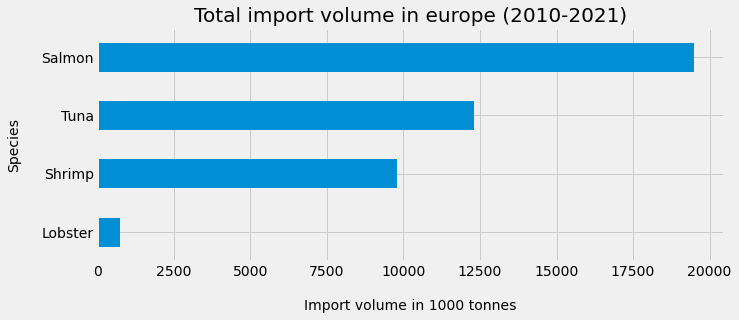

In [3036]:
# Visualize the total import volume in 1000 tonnes for main commercial species in whole europe between 2004 and 2021


total_import_volume_europe = trading_total_import.groupby("main_commercial_species").sum()/1000
display(total_import_volume_europe)

#plot bar chart
fig, ax = plt.subplots(figsize=(10,4))
(
    total_import_volume_europe
    .groupby('main_commercial_species') # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .sort_values() # sort the values in descending
    .plot.barh() # Make a bar chart based on the dataframe
)
ax.set_title('Total import volume in europe (2010-2021)', fontsize=20)

ax.set_xlabel('Import volume in 1000 tonnes',labelpad=20, fontsize=14);
ax.set_ylabel('Species',labelpad=20, fontsize=14);


## --> Most imported species in whole EU over all years was Salmon, followed by Tuna


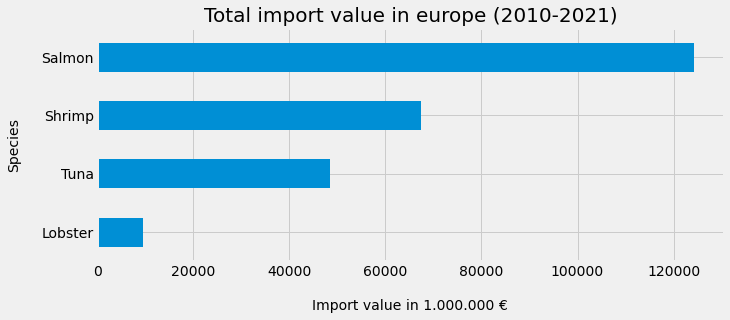

In [3037]:
# Visualize the total import value in Euro for main commercial species in whole europe between 2004 and 2021

total_import_value_europe = trading_total_import.groupby("main_commercial_species").sum()/1000000

#plot bar chart
fig, ax = plt.subplots(figsize=(10,4))
(
    total_import_value_europe
    .groupby('main_commercial_species') # aggregate data to level of airline
    .sum()['value_eur'] # count the observations
    .sort_values() # sort the values in descending
    .plot.barh() # Make a bar chart based on the dataframe
)
ax.set_title('Total import value in europe (2010-2021)', fontsize=20)

ax.set_xlabel('Import value in 1.000.000 €',labelpad=20, fontsize=14);
ax.set_ylabel('Species',labelpad=20, fontsize=14);

## --> Species with highest import value in whole EU over all years was Salmon, followed by Shrimp


#### Visualize the total volume of most imported species by country for all years

volume_t  value_eur  \
country        main_commercial_species                        
Austria        Lobster                      1.58   29831.57   
               Salmon                     107.75 1177525.29   
               Shrimp                      66.39  618784.81   
               Tuna                       132.97  693297.10   
Belgium        Lobster                     54.00  943976.87   
...                                          ...        ...   
Sweden         Tuna                        82.99  352870.99   
United Kingdom Lobster                     58.59  518139.23   
               Salmon                    1005.22 6780569.25   
               Shrimp                     977.21 8279265.46   
               Tuna                      1359.76 5519636.63   

                                        market_value_eur_per_t  
country        main_commercial_species                          
Austria        Lobster                                  659.11  
               Salmon                                   129.22  
               Shrimp                                   595.00  
               Tuna                                     714.01  
Belgium        Lobster                                  633.33  
...                                                        ...  
Sweden         Tuna                                     825.68  
United Kingdom Lobster                                  396.43  
               Salmon                                    79.92  
               Shrimp                                   548.35  
               Tuna                                     557.93  

[112 rows x 3 columns]

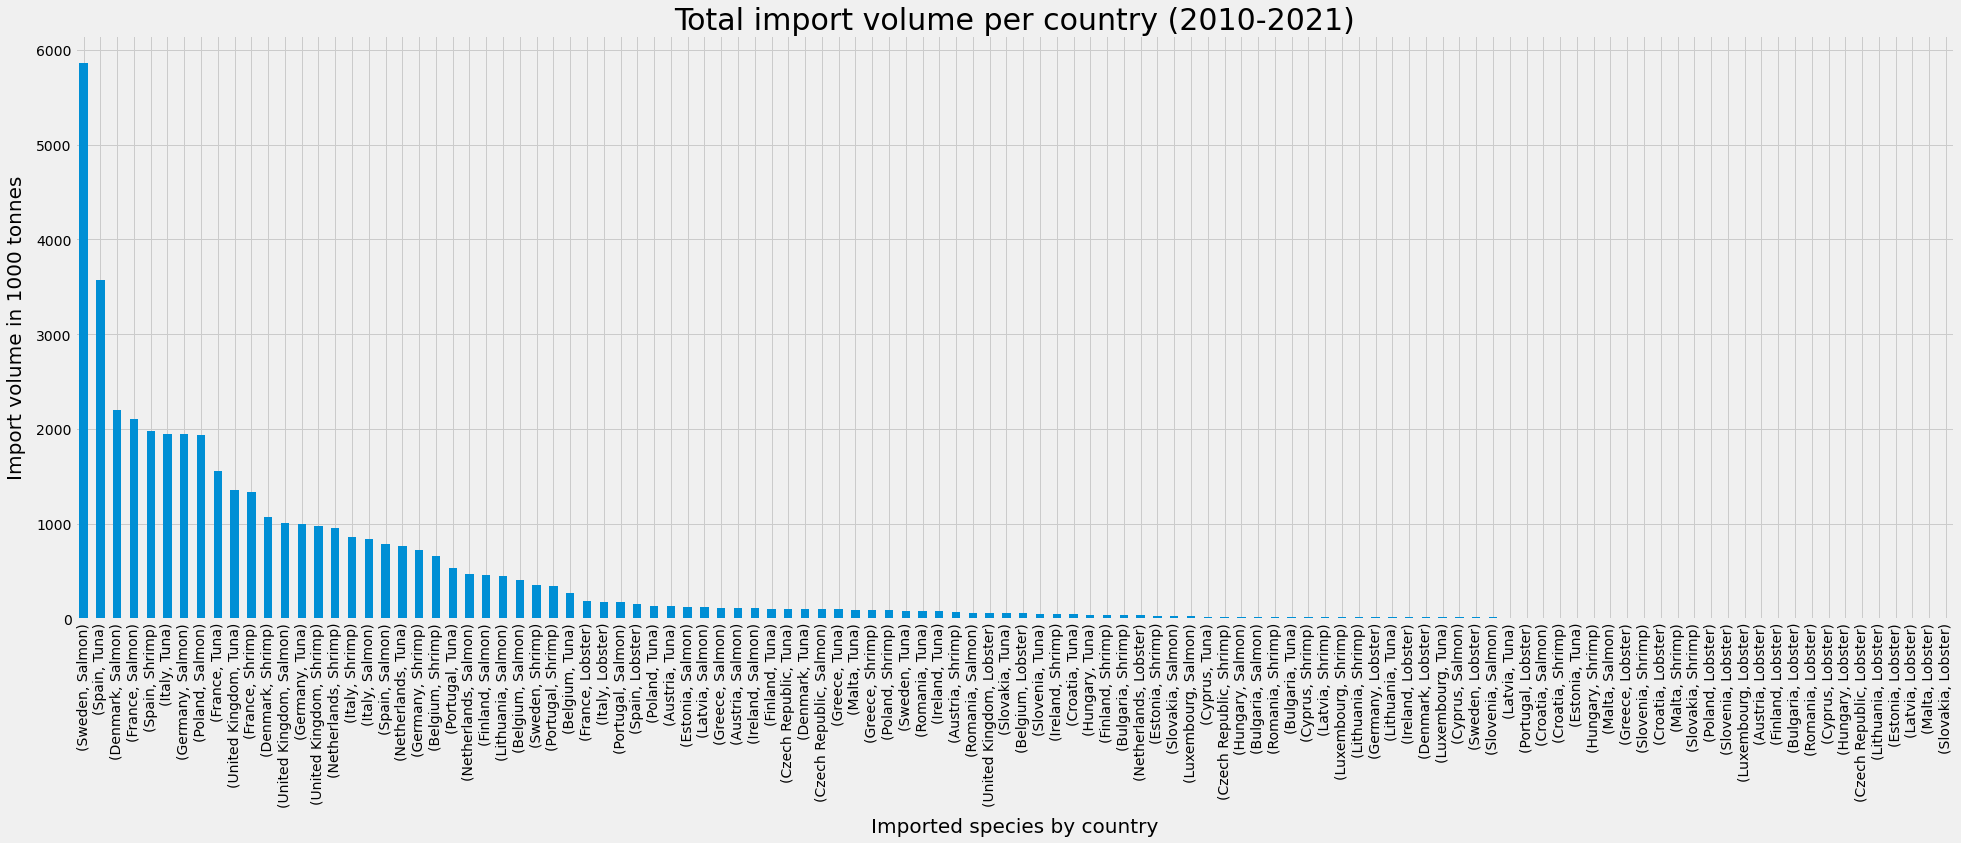

In [3038]:
# Only show countries with import volumes bigger than 0
total_import_volume_europe_bigger_zero = trading_total_import.query("volume_t > 0")

# Group table by years and main commercial species.
#Separate volumes by 1000 to make graph more readable
total_import_volume_europe1 = total_import_volume_europe_bigger_zero.groupby(["country","main_commercial_species"]).sum()/1000
display(total_import_volume_europe1)

# Plot bar chart
fig, ax = plt.subplots(figsize=(30,10))
(
    total_import_volume_europe1
    .groupby(["country","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .sort_values(ascending=False) # sort the values in descending
    .plot.bar() # Make a bar chart based on the dataframe

)
ax.set_title('Total import volume per country (2010-2021)', fontsize= 30)

ax.set_xlabel('Imported species by country',labelpad=10, fontsize=20);
ax.set_ylabel('Import volume in 1000 tonnes',labelpad=10, fontsize=20);


#### Visualize top 20 importing countries of main commercial species

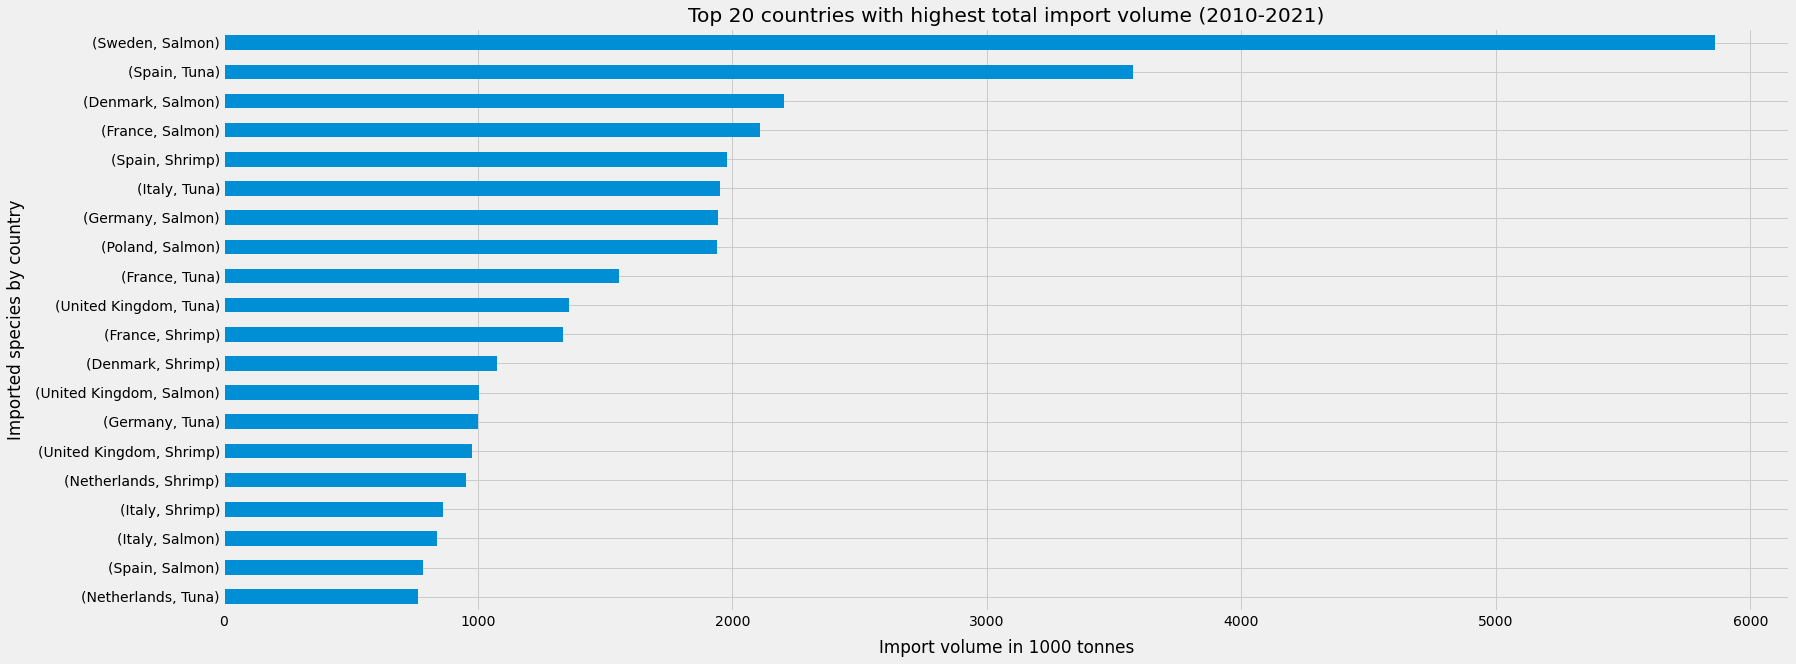

In [3039]:
# Visualize top 20 importing countries 

top_20_volume_imports = total_import_volume_europe1.nlargest(20,'volume_t')

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(25,10))
(
    top_20_volume_imports
    .groupby(["country","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .sort_values(ascending=True) # sort the values in descending
    .plot.barh() # Make a bar chart based on the dataframe

)
ax.set_title('Top 20 countries with highest total import volume (2010-2021)')

ax.set_xlabel('Import volume in 1000 tonnes',labelpad=10);
ax.set_ylabel('Imported species by country',labelpad=10);

### Detail look in top 20 countries

### Yearly import volume of species in Sweden

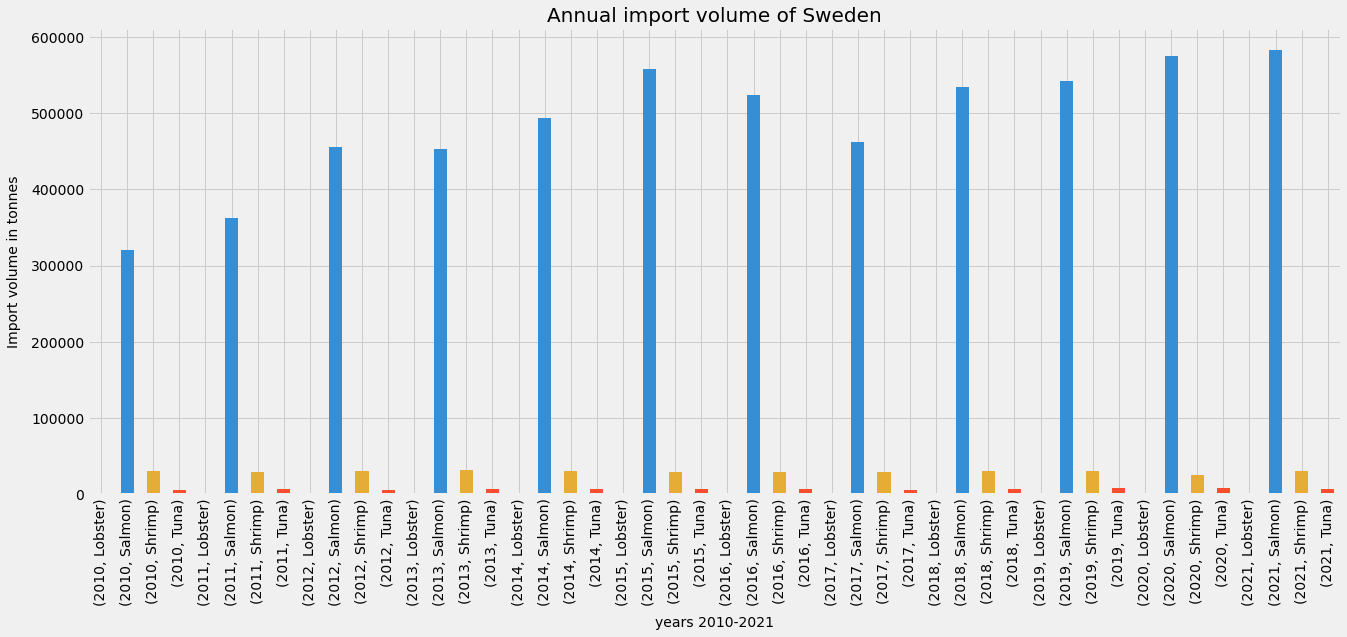

In [3040]:
#sweden_import_volume = trading_total_import.query("country == 'Sweden'").groupby(["year","main_commercial_species"]).sum()/1000

sweden_import_volume = trading_total_import.query("country == 'Sweden'")
#display(sweden_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    sweden_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t'] # count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Sweden', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in Spain

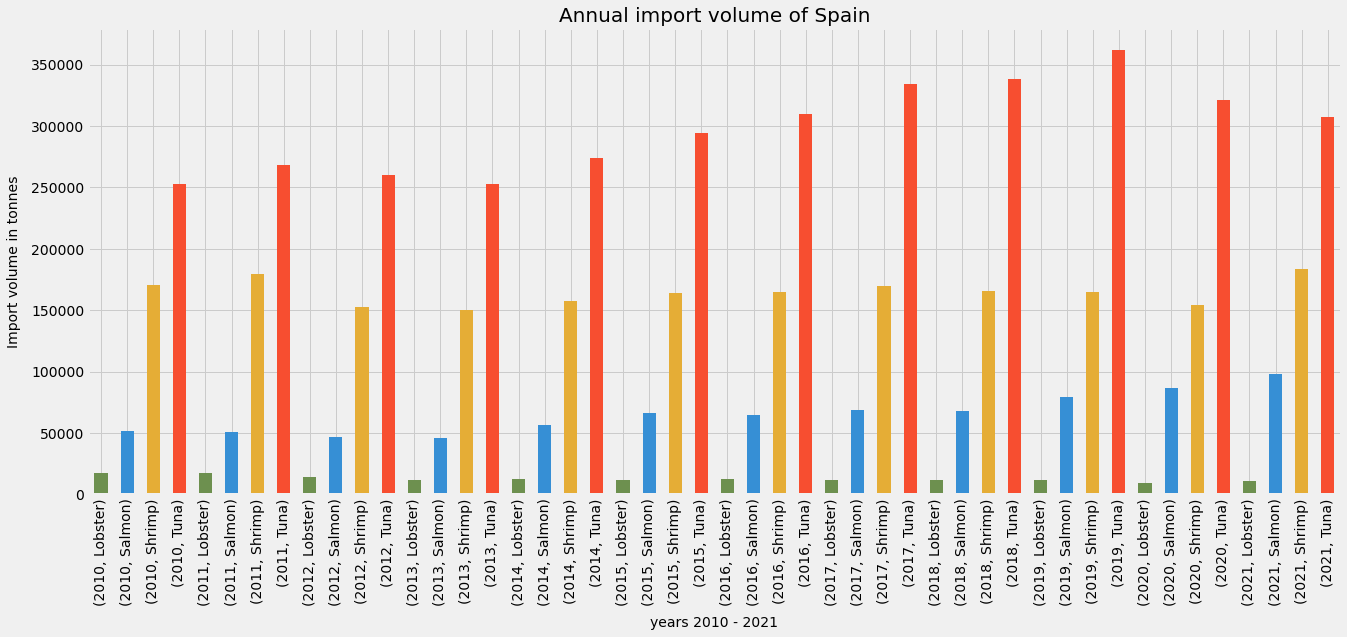

In [3041]:
spain_import_volume = trading_total_import.query("country == 'Spain'")
#display(spain_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    spain_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t'] # count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Spain', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in Denmark

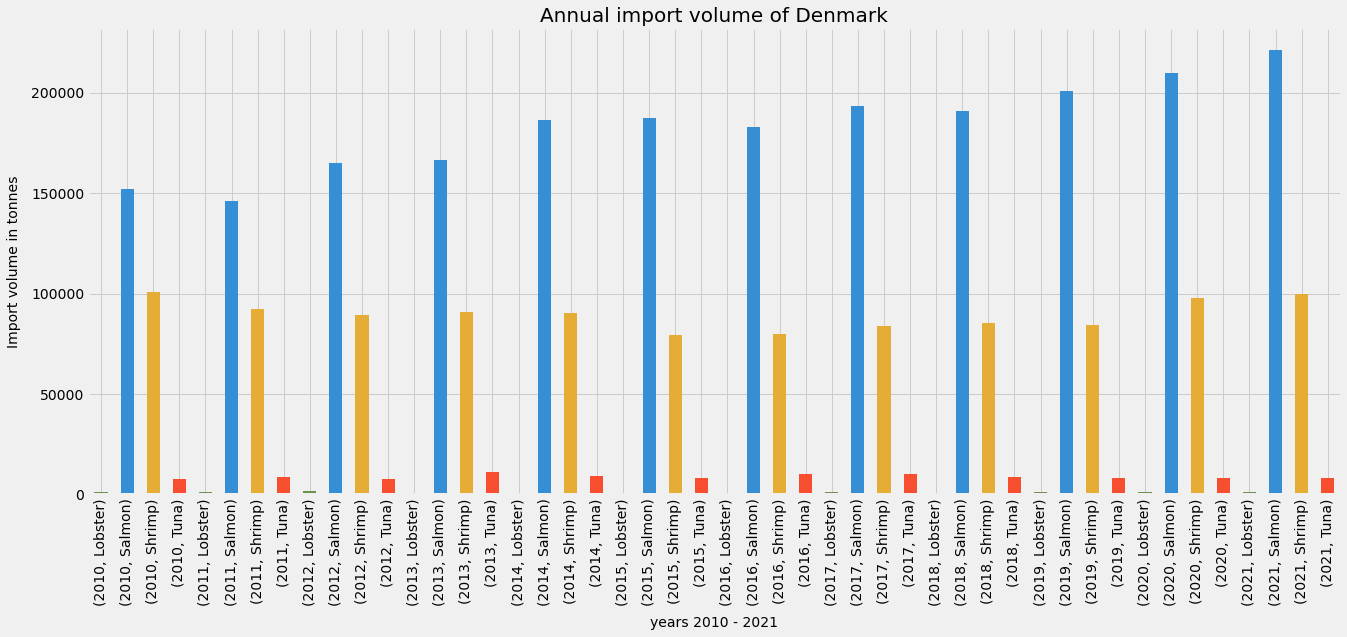

In [3042]:
denmark_import_volume = trading_total_import.query("country == 'Denmark'")
#display(denmark_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    denmark_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Denmark', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in France

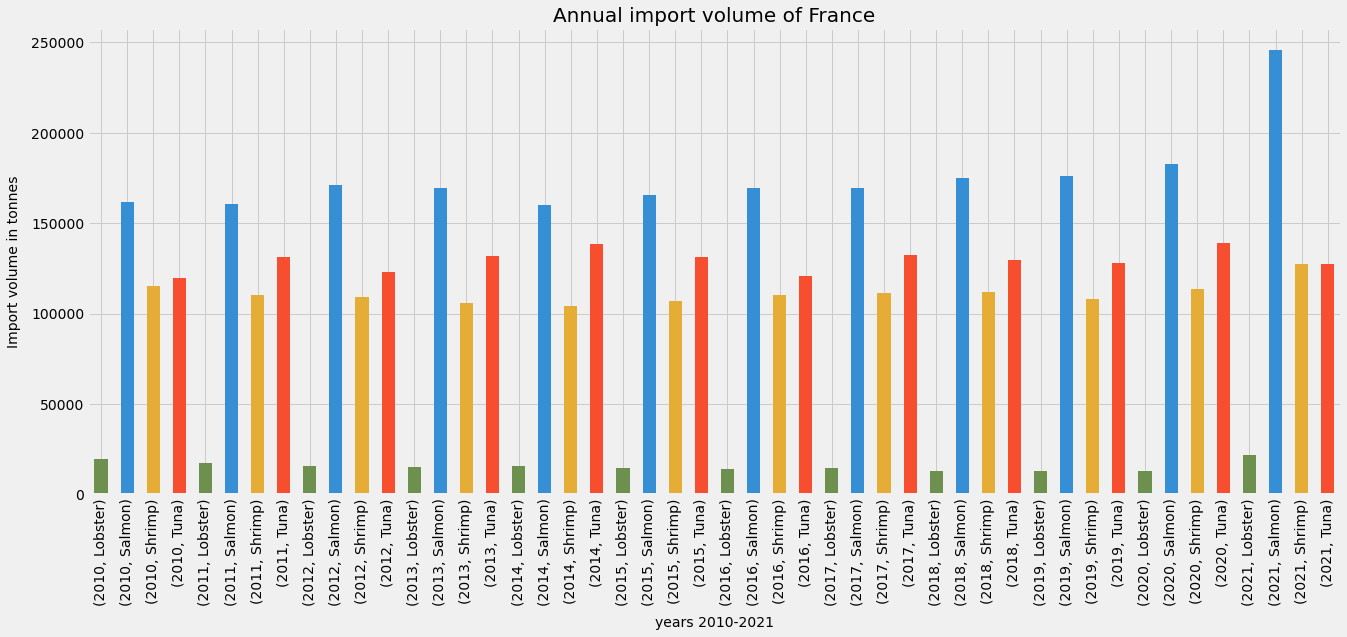

In [3043]:
france_import_volume = trading_total_import.query("country == 'France'")
#display(france_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    france_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of France', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in Italy

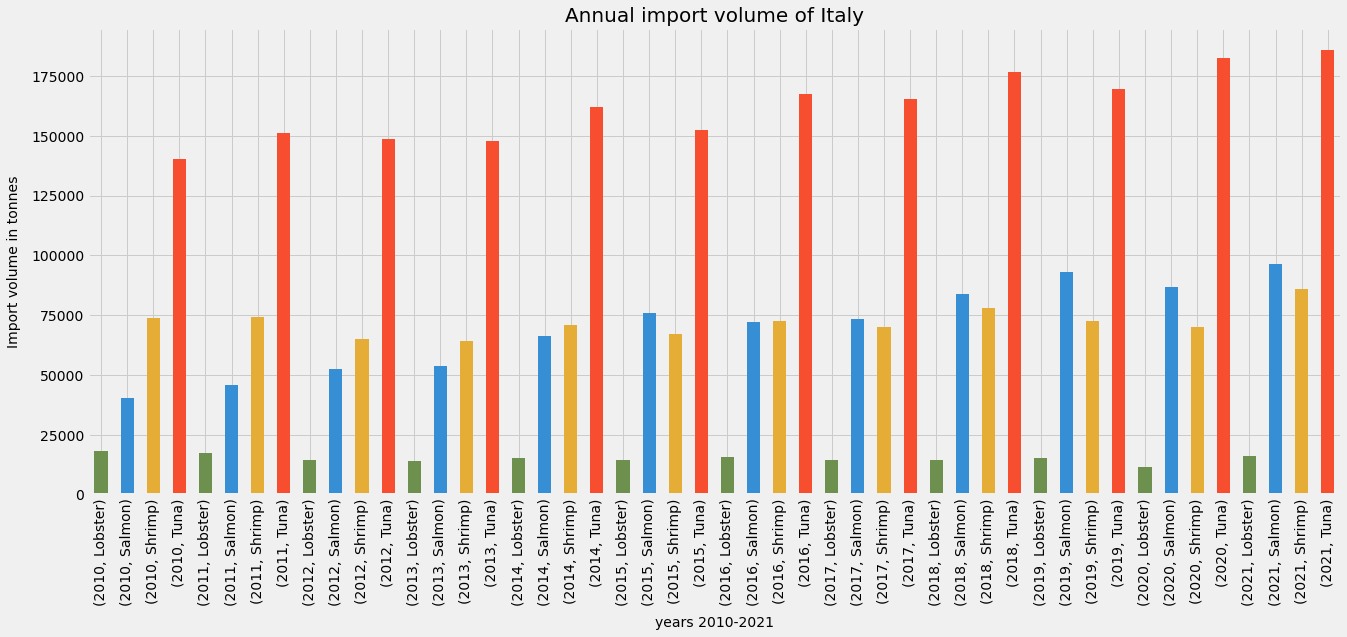

In [3044]:
italy_import_volume = trading_total_import.query("country == 'Italy'")
#display(italy_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    italy_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Italy', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in Germany

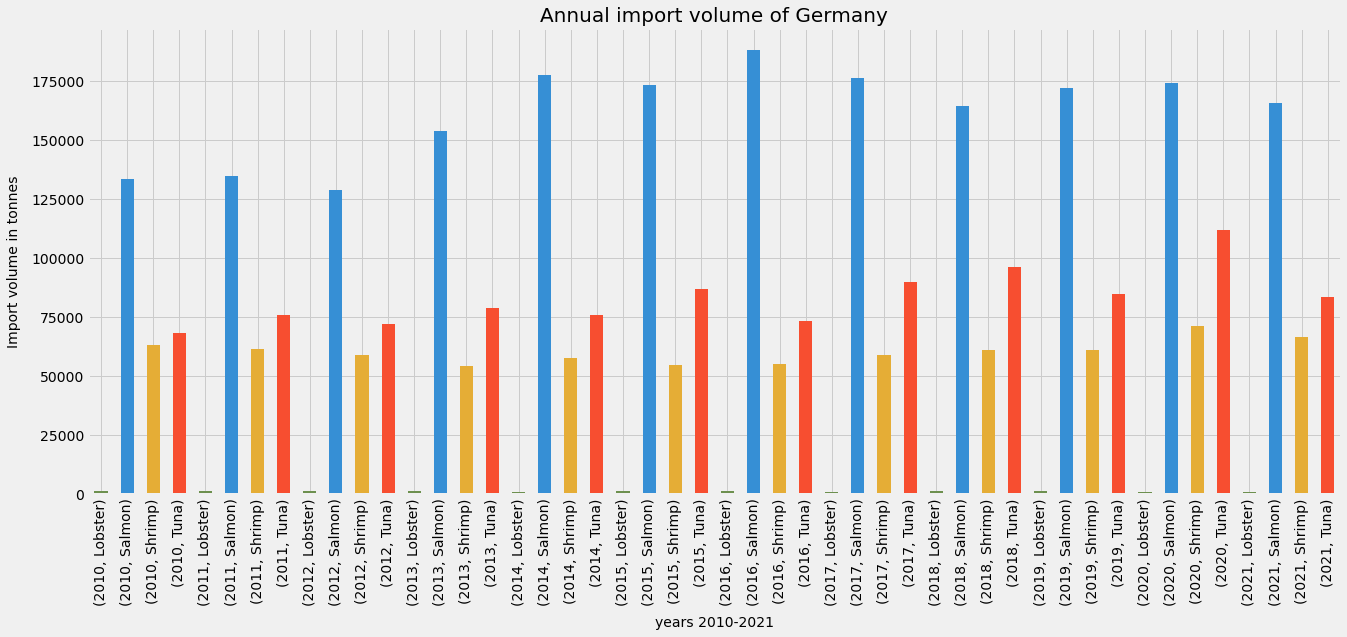

In [3045]:
germany_import_volume = trading_total_import.query("country == 'Germany'")
#display(germany_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    germany_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Germany', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in Poland

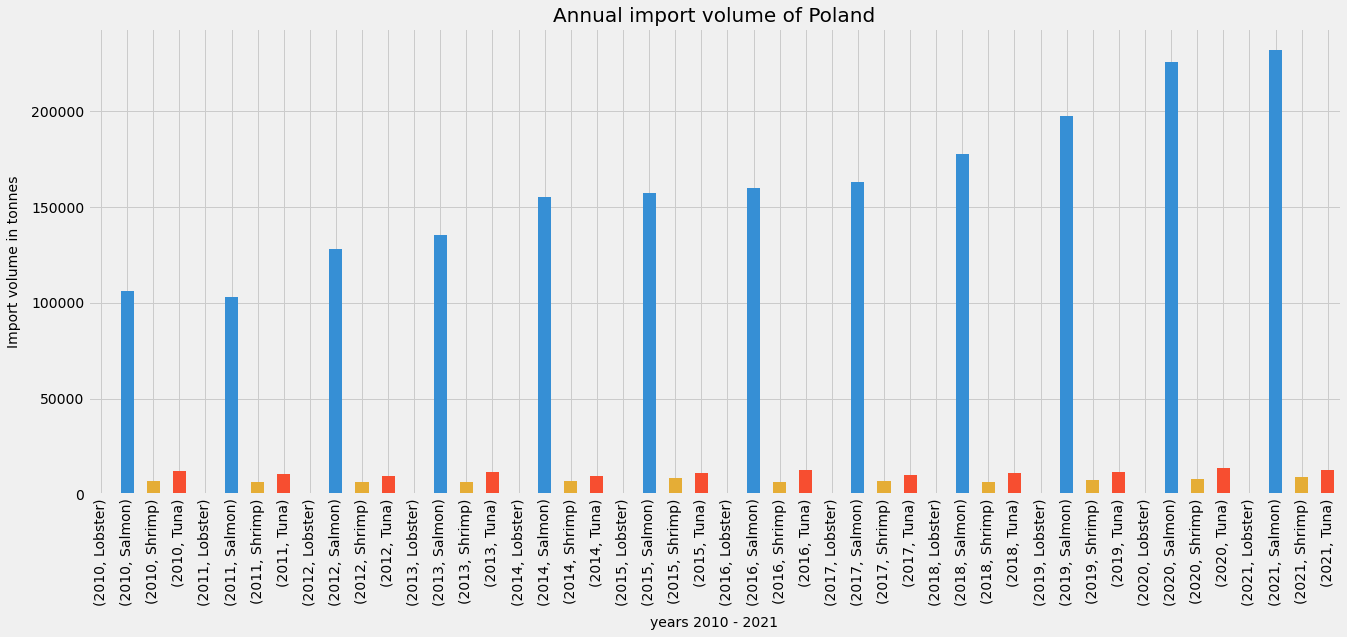

In [3046]:
poland_import_volume = trading_total_import.query("country == 'Poland'")
#display(poland_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    poland_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Poland', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in United Kingdom

In [3047]:
uk_import_volume = trading_total_import.query("country == 'United Kingdom'")
display(uk_import_volume)

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
108,2010,United Kingdom,Lobster,Crustaceans,5535.95,24965417.00,16927.55
109,2010,United Kingdom,Shrimp,Crustaceans,85719.85,502487211.00,29584.18
110,2010,United Kingdom,Tuna,Pelagic fish,112435.64,330764804.00,31943.30
111,2010,United Kingdom,Salmon,Pelagic fish,67599.41,352007878.00,5207.26
220,2011,United Kingdom,Lobster,Crustaceans,5286.84,28187771.00,19197.86
221,2011,United Kingdom,Shrimp,Crustaceans,88961.11,592765188.00,27532.45
222,2011,United Kingdom,Tuna,Pelagic fish,118277.20,382952427.00,46926.09
223,2011,United Kingdom,Salmon,Pelagic fish,71658.66,377531211.00,5268.47
332,2012,United Kingdom,Lobster,Crustaceans,5107.08,32483443.00,20722.59
333,2012,United Kingdom,Shrimp,Crustaceans,84948.37,617975283.00,42484.79


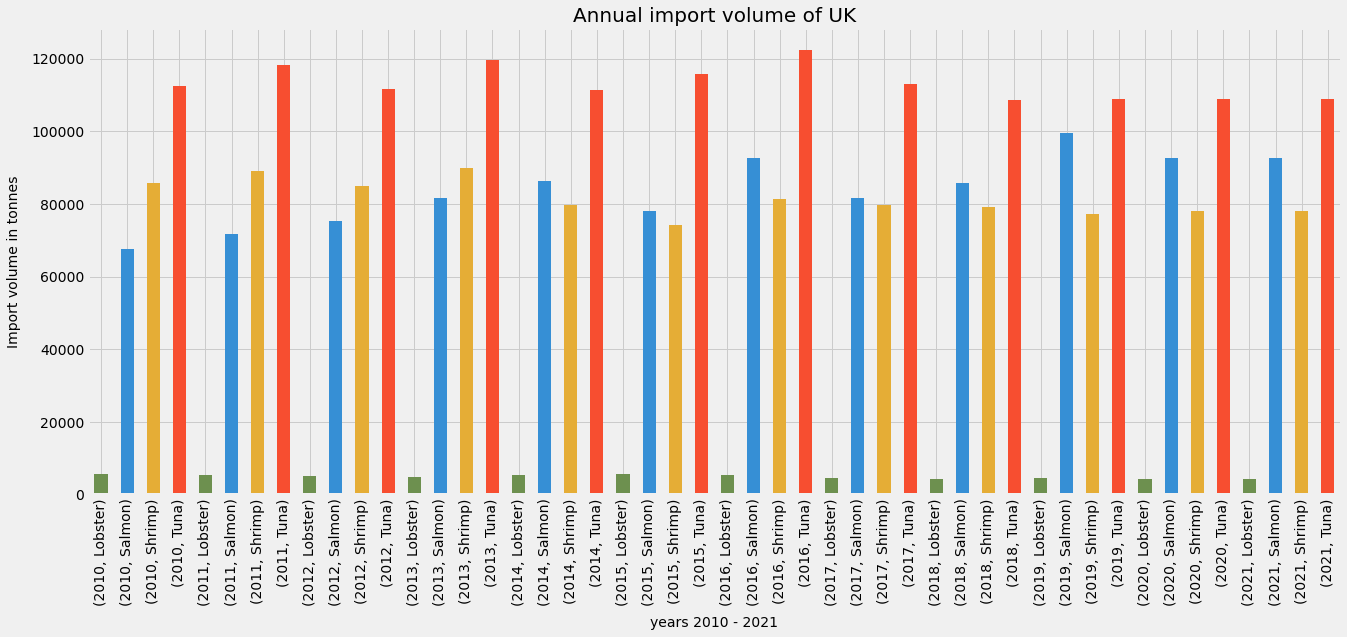

In [3048]:
uk_import_volume = trading_total_import.query("country == 'United Kingdom'")
#display(uk_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    uk_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of UK', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);

### Yearly import volume of species in Netherlands

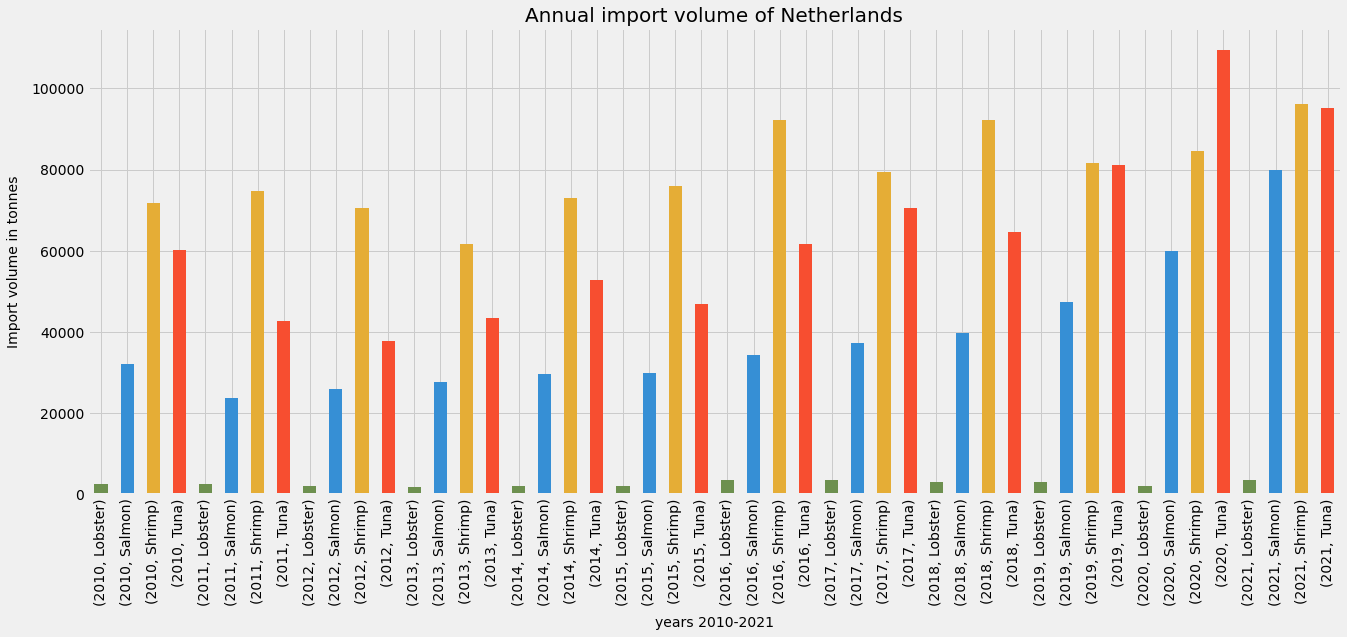

In [3049]:
netherlands_import_volume = trading_total_import.query("country == 'Netherlands'")
#display(netherlands_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    netherlands_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Netherlands', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);


### Yearly import volume of species in Belgium

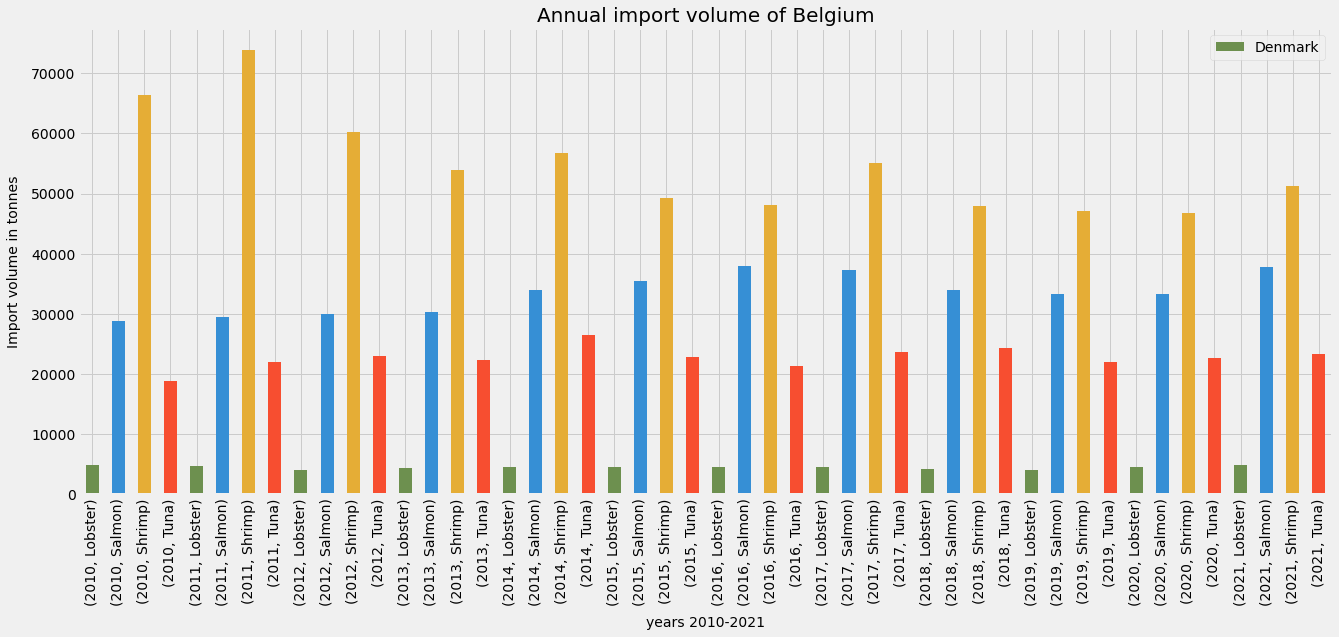

In [3050]:
belgium_import_volume = trading_total_import.query("country == 'Belgium'")
#display(belgium_import_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    belgium_import_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual import volume of Belgium', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 14);
ax.set_ylabel('Import volume in tonnes',labelpad=10, fontsize =14);
plt.legend(["Denmark", "Germany", "France", "Italy"], loc="best");


### Visualize annual total import volume of all main commercial species

,volume_t,value_eur,market_value_eur_per_t
year,,,
2010,3002.62,14242362.42,3264.86
2011,3095.21,15148432.40,3034.23
2012,3155.36,15622039.60,3492.08
2013,3217.49,18089512.05,3276.54
2014,3451.96,19567885.78,3528.80
2015,3516.97,20265141.09,3718.91
2016,3584.10,22993239.90,3767.82
2017,3611.35,24320494.51,3949.22
2018,3730.98,24692125.25,3995.51


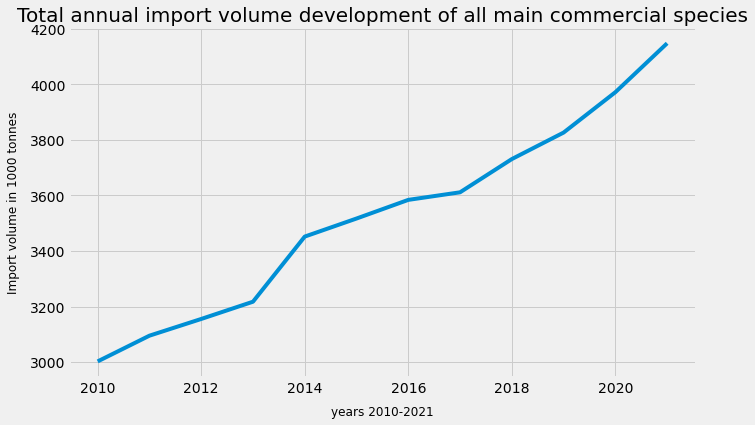

In [3051]:
# Visualize total import volume year by year
yearly_total_volume_import= trading_total_import.groupby("year").sum()/1000
display(yearly_total_volume_import)

# Plot line chart
fig, ax = plt.subplots(figsize=(10,6))
(
    yearly_total_volume_import
    .groupby("year") # aggregate data to years
    .sum()['volume_t'] # count total volume
    .plot() # Make a line chart based on the dataframe

)
ax.set_title('Total annual import volume development of all main commercial species', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 12);
ax.set_ylabel('Import volume in 1000 tonnes',labelpad=10, fontsize =12);

### Visualize annual total import value of all main commercial species

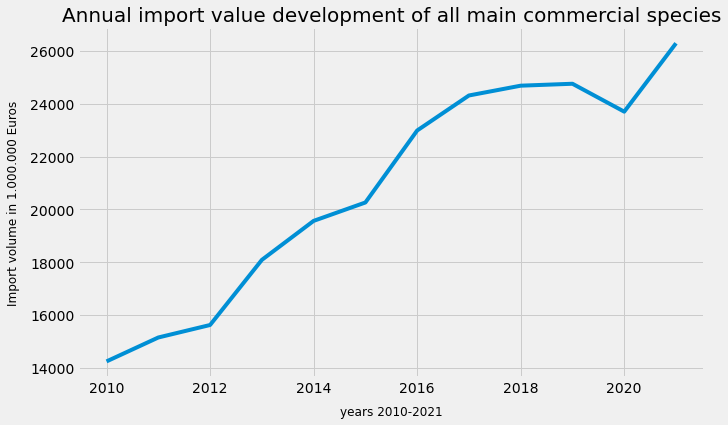

In [3052]:
# Visualize total import value year by year
#display(trading_total_import)

# Group by years and divide euros by 1.000.000 to make graph more readable
yearly_total_volume_import= trading_total_import.groupby("year").sum()/1000000

# Plot line chart 
fig, ax = plt.subplots(figsize=(10,6))
(
    yearly_total_volume_import
    .groupby("year") # aggregate data to years
    .sum()['value_eur'] # count total volume
    .plot() # Make a line chart based on the dataframe

)
ax.set_title('Annual import value development of all main commercial species', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 12);
ax.set_ylabel('Import volume in 1.000.000 Euros',labelpad=10, fontsize =12);

### Development of total import volumes of species in detail year by year

### Salmon development of total import volumes 

,,volume_t,value_eur,market_value_eur_per_t
year,main_commercial_species,,,
2010,Salmon,1189.64,6438523.54,160.45
2011,Salmon,1243.49,6513570.46,160.64
2012,Salmon,1417.93,6629226.32,150.40
2013,Salmon,1457.02,8549257.74,186.08
2014,Salmon,1613.03,9474065.57,184.14
2015,Salmon,1693.61,9812959.43,180.80
2016,Salmon,1680.78,12086478.25,216.93
2017,Salmon,1638.09,12444511.19,230.15
2018,Salmon,1740.57,12820405.75,225.71


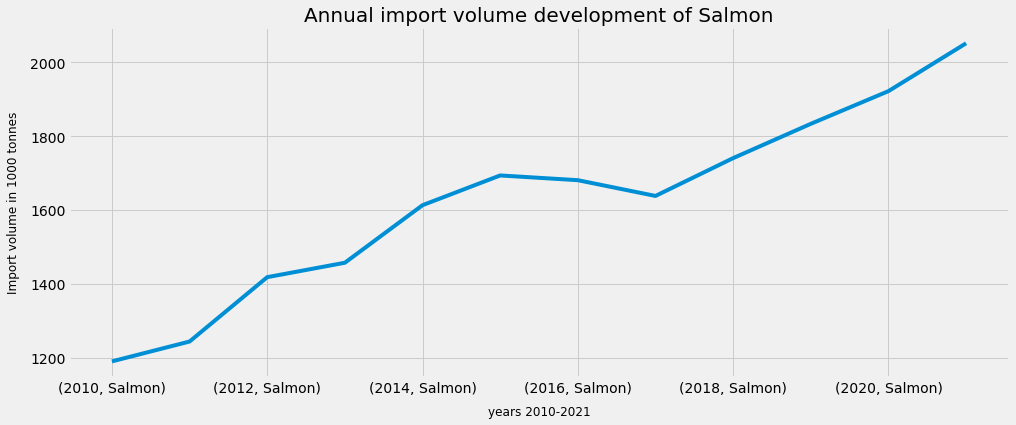

In [3053]:
# Visualize total import value of Salmon

# Group species and divide tonnes by 1.000 to make graph more readable
salmon_yearly_species_development= trading_total_import.query("main_commercial_species == 'Salmon'").groupby(["year","main_commercial_species"]).sum()/1000
display(salmon_yearly_species_development)

# Plot line chart
salmon = fig, ax = plt.subplots(figsize=(15,6))
(
    salmon_yearly_species_development
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)
ax.set_title('Annual import volume development of Salmon', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 12);
ax.set_ylabel('Import volume in 1000 tonnes',labelpad=10, fontsize =12);

### Shrimp development of total import volumes 

,,volume_t,value_eur,market_value_eur_per_t
year,main_commercial_species,,,
2010,Shrimp,846.95,4470978.34,1034.35
2011,Shrimp,847.18,4787464.77,907.16
2012,Shrimp,780.62,4692435.55,1246.58
2013,Shrimp,761.63,4872941.94,1022.70
2014,Shrimp,787.62,5660253.52,1126.22
2015,Shrimp,768.00,5868260.79,1205.24
2016,Shrimp,804.54,6113825.03,1217.41
2017,Shrimp,812.46,6399233.42,1263.43
2018,Shrimp,831.87,6234803.80,1230.33


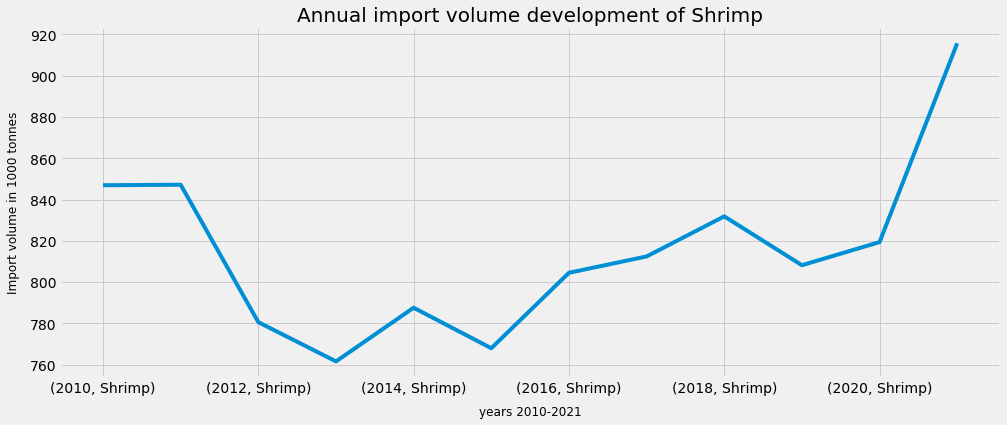

In [3054]:
# Visualize total import volumes of Shrimp

# Group species and divide tonnes by 1.000 to make graph more readable
shrimp_yearly_species_development= trading_total_import.query("main_commercial_species == 'Shrimp'").groupby(["year","main_commercial_species"]).sum()/1000
display(shrimp_yearly_species_development)

# Plot line chart
fig, ax = plt.subplots(figsize=(15,6))
(
    shrimp_yearly_species_development
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)

ax.set_title('Annual import volume development of Shrimp', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 12);
ax.set_ylabel('Import volume in 1000 tonnes',labelpad=10, fontsize =12);

### Tuna development of total import volumes 

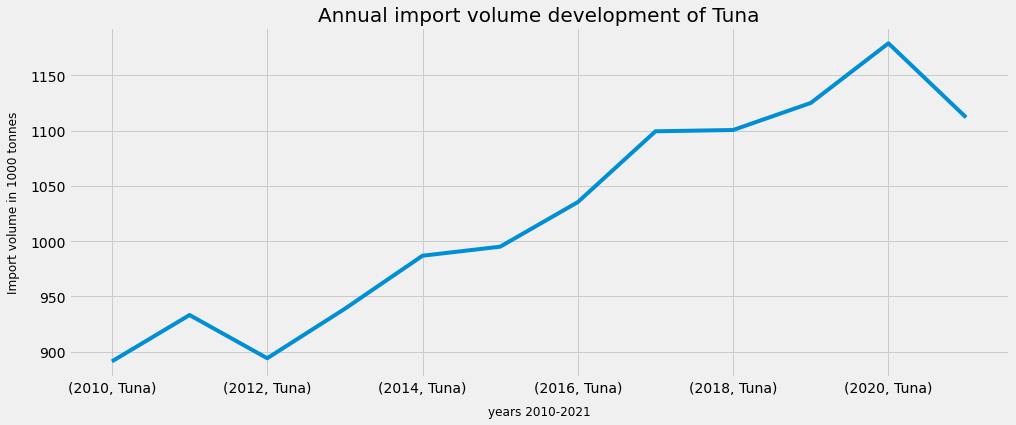

In [3055]:
# Visualize total import volumes of Tuna

# Group species and divide tonnes by 1.000 to make graph more readable
tuna_yearly_species_development= trading_total_import.query("main_commercial_species == 'Tuna'").groupby(["year","main_commercial_species"]).sum()/1000
#display(tuna_yearly_species_development)

# Plot line chart
fig, ax = plt.subplots(figsize=(15,6))
(
    tuna_yearly_species_development
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)

ax.set_title('Annual import volume development of Tuna', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 12);
ax.set_ylabel('Import volume in 1000 tonnes',labelpad=10, fontsize =12);

### Lobster development of total import volumes 

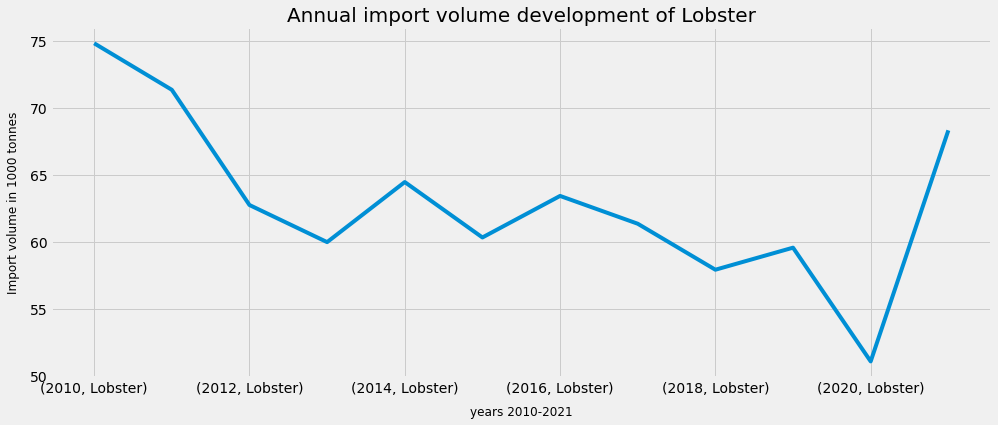

In [3056]:
# Visualize total import volumes of Lobster

# Group species and divide tonnes by 1.000 to make graph more readable
lobster_yearly_species_development= trading_total_import.query("main_commercial_species == 'Lobster'").groupby(["year","main_commercial_species"]).sum()/1000
#display(lobster_yearly_species_development)

# Plot line chart
fig, ax = plt.subplots(figsize=(15,6))
(
    lobster_yearly_species_development
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)

ax.set_title('Annual import volume development of Lobster', fontsize =20)
ax.set_xlabel('years 2010-2021',labelpad=10, fontsize= 12);
ax.set_ylabel('Import volume in 1000 tonnes',labelpad=10, fontsize =12);

### Development of total annual import volumes of species in one graph

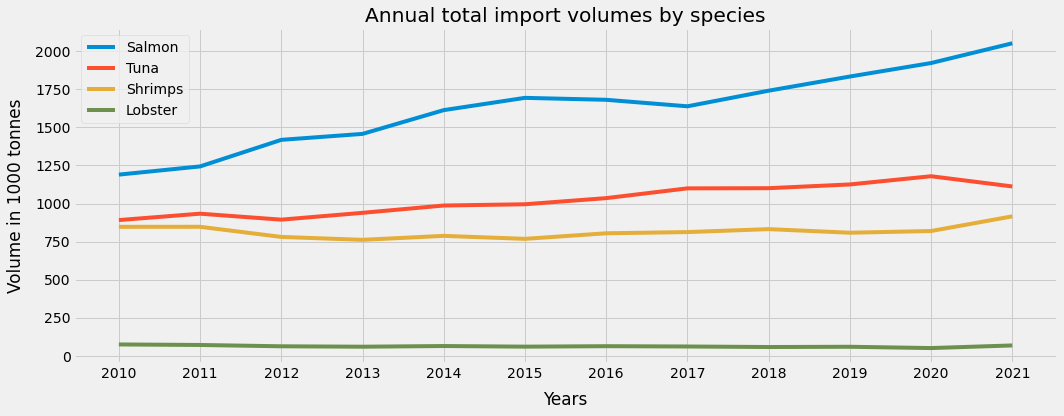

In [3057]:
# Visualize development of annual import volume of main commercial species

# Create labels and y-axes-values
labels = ['2010', '2011', '2012', '2013','2014','2015', '2016', '2017', '2018','2019','2020','2021']
shrimp_means = shrimp_yearly_species_development["volume_t"]
salmon_means = salmon_yearly_species_development["volume_t"]
lobster_means = lobster_yearly_species_development["volume_t"]
tuna_means = tuna_yearly_species_development["volume_t"]

x = np.arange(len(labels))  # the label locations

#plot the line charts
fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.plot(x, salmon_means,label='Salmon')
rects2 = ax.plot(x, tuna_means, label='Tuna')
rects3 = ax.plot(x, shrimp_means,label='Shrimps')
rects4 = ax.plot(x, lobster_means,label='Lobster')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Years',labelpad=10)
ax.set_ylabel('Volume in 1000 tonnes',labelpad=10)
ax.set_title('Annual total import volumes by species')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Development of total annual import value of species in one graph

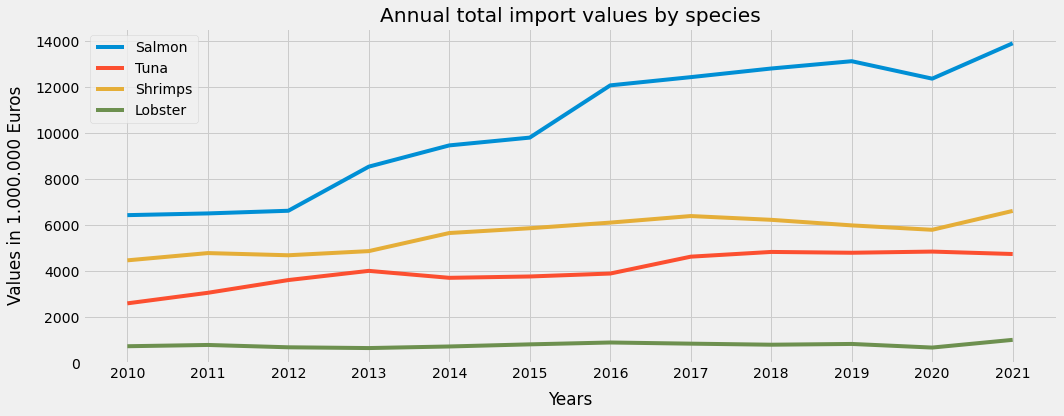

In [3058]:
# Visualize development of annual import values of main commercial species

# Group species and divide euros by 1.000.000 to make graph more readable
lobster_yearly_species_value_development= trading_total_import.query("main_commercial_species == 'Lobster'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(lobster_yearly_species_value_development)
shrimp_yearly_species_value_development= trading_total_import.query("main_commercial_species == 'Shrimp'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(shrimp_yearly_species_value_development)
tuna_yearly_species_value_development= trading_total_import.query("main_commercial_species == 'Tuna'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(tuna_yearly_species_value_development)
salmon_yearly_species_value_development= trading_total_import.query("main_commercial_species == 'Salmon'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(salmon_yearly_species_value_development)

# Create labels and y-axes-values
labels = ['2010', '2011', '2012', '2013','2014','2015', '2016', '2017', '2018','2019','2020','2021']
shrimp_value = shrimp_yearly_species_value_development["value_eur"]
salmon_value = salmon_yearly_species_value_development["value_eur"]
lobster_value = lobster_yearly_species_value_development["value_eur"]
tuna_value = tuna_yearly_species_value_development["value_eur"]

x = np.arange(len(labels))  # the label locations

#Plot the line charts
fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.plot(x, salmon_value,label='Salmon')
rects2 = ax.plot(x, tuna_value, label='Tuna')
rects3 = ax.plot(x, shrimp_value,label='Shrimps')
rects4 = ax.plot(x, lobster_value,label='Lobster')


# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Years',labelpad=10)
ax.set_ylabel('Values in 1.000.000 Euros',labelpad=10)
ax.set_title('Annual total import values by species')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Development of total annual market_value of species in one graph

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,147.38,2405963.00,49711.50
1,2010,Austria,Shrimp,Crustaceans,4412.82,32462723.00,45279.72
2,2010,Austria,Tuna,Pelagic fish,9092.00,34975793.00,42071.28
3,2010,Austria,Salmon,Pelagic fish,7076.20,59317843.00,8382.73
4,2010,Belgium,Lobster,Crustaceans,4879.10,66587547.00,41348.17
...,...,...,...,...,...,...,...
1339,2021,Sweden,Salmon,Pelagic fish,582427.00,3569818000.00,6129.21
1340,2021,United Kingdom,Lobster,Crustaceans,4295.91,48810908.00,42105.28
1341,2021,United Kingdom,Shrimp,Crustaceans,78174.98,712761506.50,56192.56
1342,2021,United Kingdom,Tuna,Pelagic fish,108783.93,489753186.50,56034.90


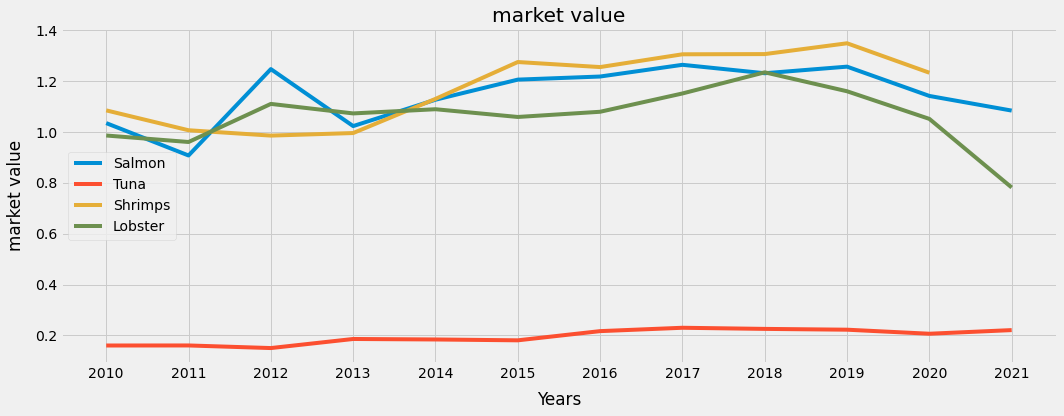

In [3059]:
# Visualize development of annual market value in euro per tonnes per species
display(trading_total_import)

# Group species and divide euros by 1.000.000 to make graph more readable
lobster_yearly_species_market_value_development= trading_total_import.query("main_commercial_species == 'Lobster'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(lobster_yearly_species_market_value_development)
shrimp_yearly_species_market_value_development= trading_total_import.query("main_commercial_species == 'Shrimp'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(shrimp_yearly_species_market_value_development)
tuna_yearly_species_market_value_development= trading_total_import.query("main_commercial_species == 'Tuna'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(tuna_yearly_species_market_value_development)
salmon_yearly_species_market_value_development= trading_total_import.query("main_commercial_species == 'Salmon'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(salmon_yearly_species_market_value_development)

# Create labels and y-axes-values
labels = ['2010', '2011', '2012', '2013','2014','2015', '2016', '2017', '2018','2019','2020','2021']
shrimp_market_value = shrimp_yearly_species_market_value_development["market_value_eur_per_t"]
salmon_market_value = salmon_yearly_species_market_value_development["market_value_eur_per_t"]
lobster_market_value = lobster_yearly_species_market_value_development["market_value_eur_per_t"]
tuna_market_value = tuna_yearly_species_market_value_development["market_value_eur_per_t"]

x = np.arange(len(labels))  # the label locations

#Plot the line charts
fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.plot(x, shrimp_market_value, label='Salmon')
rects2 = ax.plot(x, salmon_market_value, label='Tuna')
rects3 = ax.plot(x, lobster_market_value ,label='Shrimps')
rects4 = ax.plot(x, tuna_market_value,label='Lobster')


# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Years',labelpad=10)
ax.set_ylabel('market value',labelpad=10)
ax.set_title('market value')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [3060]:
# upload dataframe in dbeaver

table_name = 'trading_total_import_country_species'
engine = get_engine()
schema = 'capstone_fish_are_friends'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This may take some time ...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        trading_total_import.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The trading_total_import_country_species table was imported successfully.


## 1.1.b Species Categories

## 1.2 Which species are exported the most in which countries?

## 1.2.a Species in Detail

In [3061]:
#change datatype years to strings
trading_total_export.year = trading_total_export.year.astype(str)
trading_total_export.head()

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,1.60,35925.00,67562.93
1,2010,Austria,Shrimp,Crustaceans,244.09,2000431.00,48341.42
2,2010,Austria,Tuna,Pelagic fish,927.86,3108591.00,60318.00
3,2010,Austria,Salmon,Pelagic fish,310.91,2989229.00,9614.42
4,2010,Belgium,Lobster,Crustaceans,2870.50,44808625.00,42657.43


,volume_t,value_eur,market_value_eur_per_t
main_commercial_species,,,
Lobster,534.90,6374397.24,NaN
Salmon,11935.38,84292680.63,2824.74
Shrimp,4088.01,28839110.23,18606.48
Tuna,6813.74,24271600.96,NaN


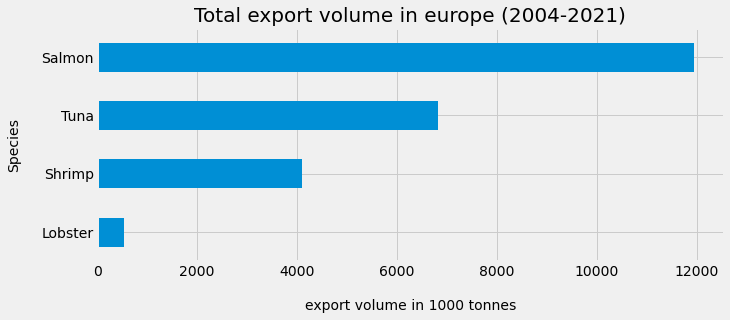

In [3062]:
# Visualize the total export volume in 1000 tonnes for main commercial species in whole europe between 2004 and 2021
total_export_volume_europe = trading_total_export.groupby("main_commercial_species").sum()/1000
display(total_export_volume_europe)

#plot bar chart
fig, ax = plt.subplots(figsize=(10,4))
(
    total_export_volume_europe
    .groupby('main_commercial_species') # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .sort_values() # sort the values in descending
    .plot.barh() # Make a bar chart based on the dataframe
)
ax.set_title('Total export volume in europe (2004-2021)', fontsize=20)

ax.set_xlabel('export volume in 1000 tonnes',labelpad=20, fontsize=14);
ax.set_ylabel('Species',labelpad=20, fontsize=14);


## --> Most exported species in whole EU over all years was Salmon, followed by Tuna


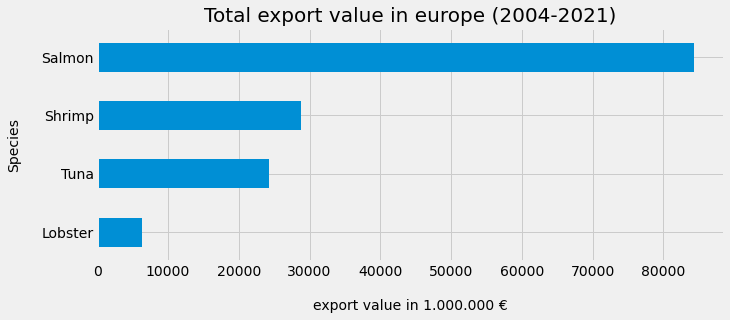

In [3063]:
# Visualize the total export value in Euro for main commercial species in whole europe between 2004 and 2021

total_export_value_europe = trading_total_export.groupby("main_commercial_species").sum()/1000000

#plot bar chart
fig, ax = plt.subplots(figsize=(10,4))
(
    total_export_value_europe
    .groupby('main_commercial_species') # aggregate data to level of airline
    .sum()['value_eur'] # count the observations
    .sort_values() # sort the values in descending
    .plot.barh() # Make a bar chart based on the dataframe
)
ax.set_title('Total export value in europe (2004-2021)', fontsize=20)

ax.set_xlabel('export value in 1.000.000 €',labelpad=20, fontsize=14);
ax.set_ylabel('Species',labelpad=20, fontsize=14);

## --> Species with highest export value in whole EU over all years was Salmon, followed by Shrimp


### Visualize the total volume of most exported species by country for all years

volume_t  value_eur  \
country        main_commercial_species                        
Austria        Lobster                      0.11    1493.88   
               Salmon                      10.75  146647.55   
               Shrimp                       6.21   50978.58   
               Tuna                        12.79   61245.66   
Belgium        Lobster                     40.03  693714.12   
...                                          ...        ...   
Sweden         Tuna                         3.19   18587.36   
United Kingdom Lobster                    222.64 2237132.29   
               Salmon                    1293.47 8560064.64   
               Shrimp                     155.60 1127127.29   
               Tuna                        72.68  307533.73   

                                        market_value_eur_per_t  
country        main_commercial_species                          
Austria        Lobster                                  615.04  
               Salmon                                   155.37  
               Shrimp                                   504.63  
               Tuna                                     621.03  
Belgium        Lobster                                  587.09  
...                                                        ...  
Sweden         Tuna                                        inf  
United Kingdom Lobster                                  429.10  
               Salmon                                    78.97  
               Shrimp                                   437.53  
               Tuna                                     682.61  

[111 rows x 3 columns]

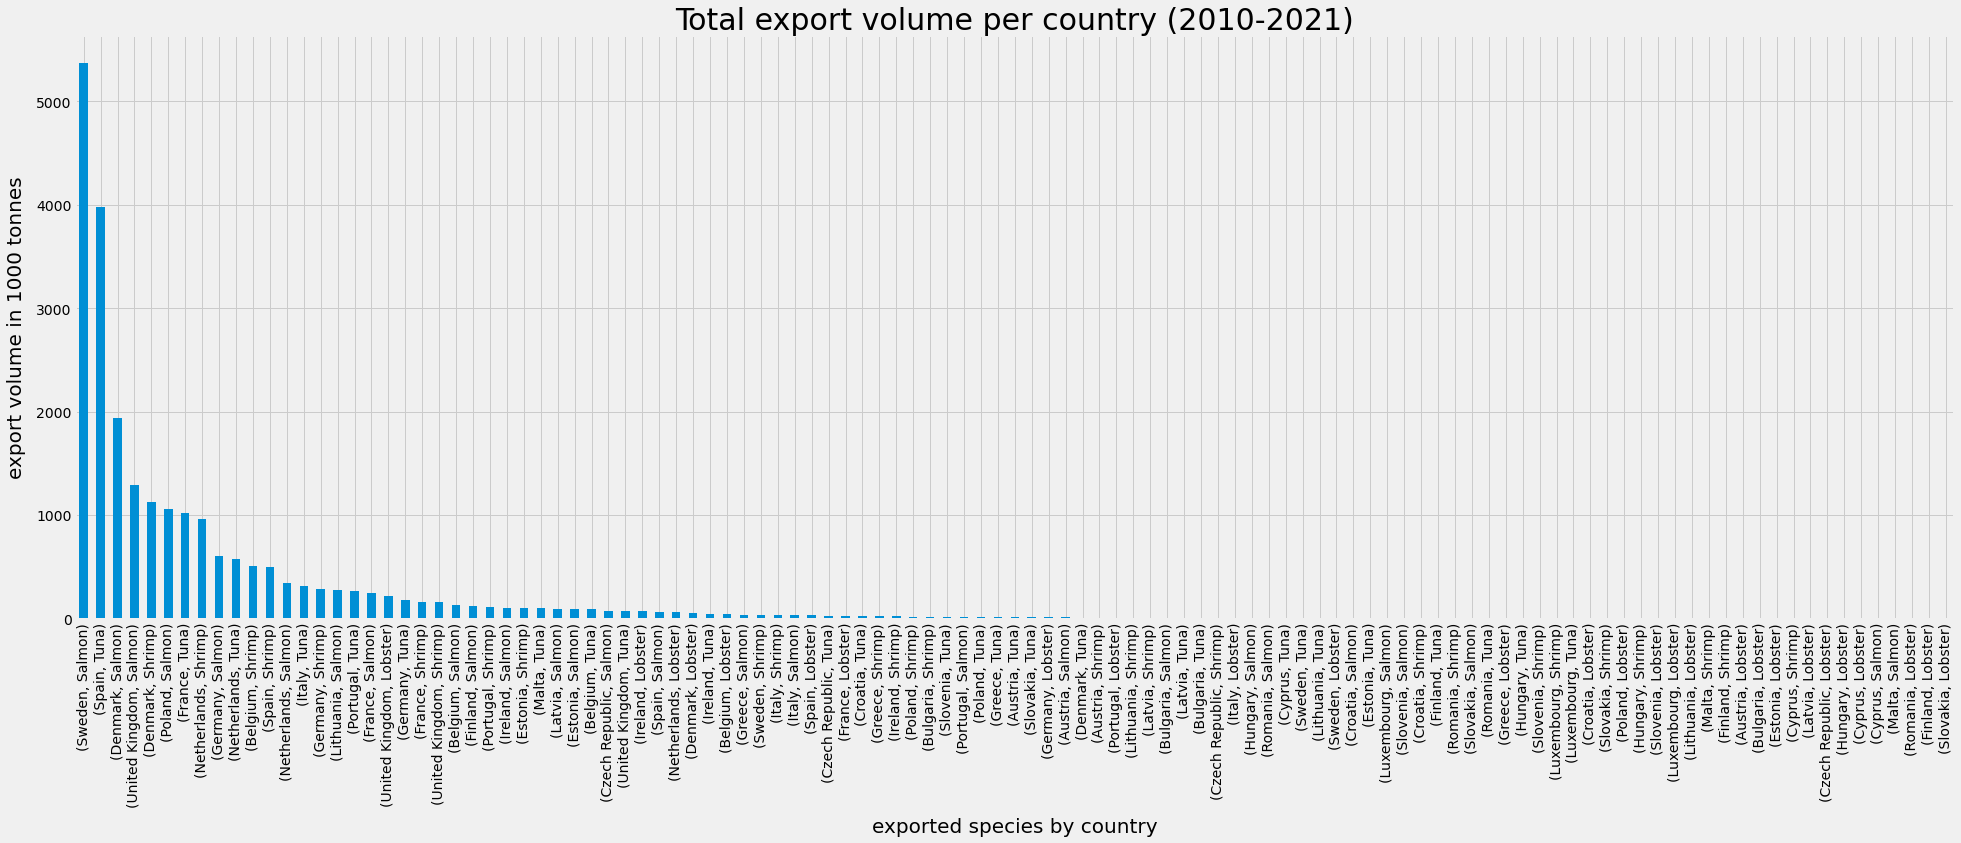

In [3064]:
# Only show countries with export volumes bigger than 0
total_export_volume_europe_bigger_zero = trading_total_export.query("volume_t > 0")

# Group table by years and main commercial species.
#Separate volumes by 1000 to make graph more readable
total_export_volume_europe1 = total_export_volume_europe_bigger_zero.groupby(["country","main_commercial_species"]).sum()/1000
display(total_export_volume_europe1)

# Plot bar chart
fig, ax = plt.subplots(figsize=(30,10))
(
    total_export_volume_europe1
    .groupby(["country","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .sort_values(ascending=False) # sort the values in descending
    .plot.bar() # Make a bar chart based on the dataframe

)
ax.set_title('Total export volume per country (2010-2021)', fontsize= 30)

ax.set_xlabel('exported species by country',labelpad=10, fontsize=20);
ax.set_ylabel('export volume in 1000 tonnes',labelpad=10, fontsize=20);


### Visualize top 20 exporting countries of main commercial species

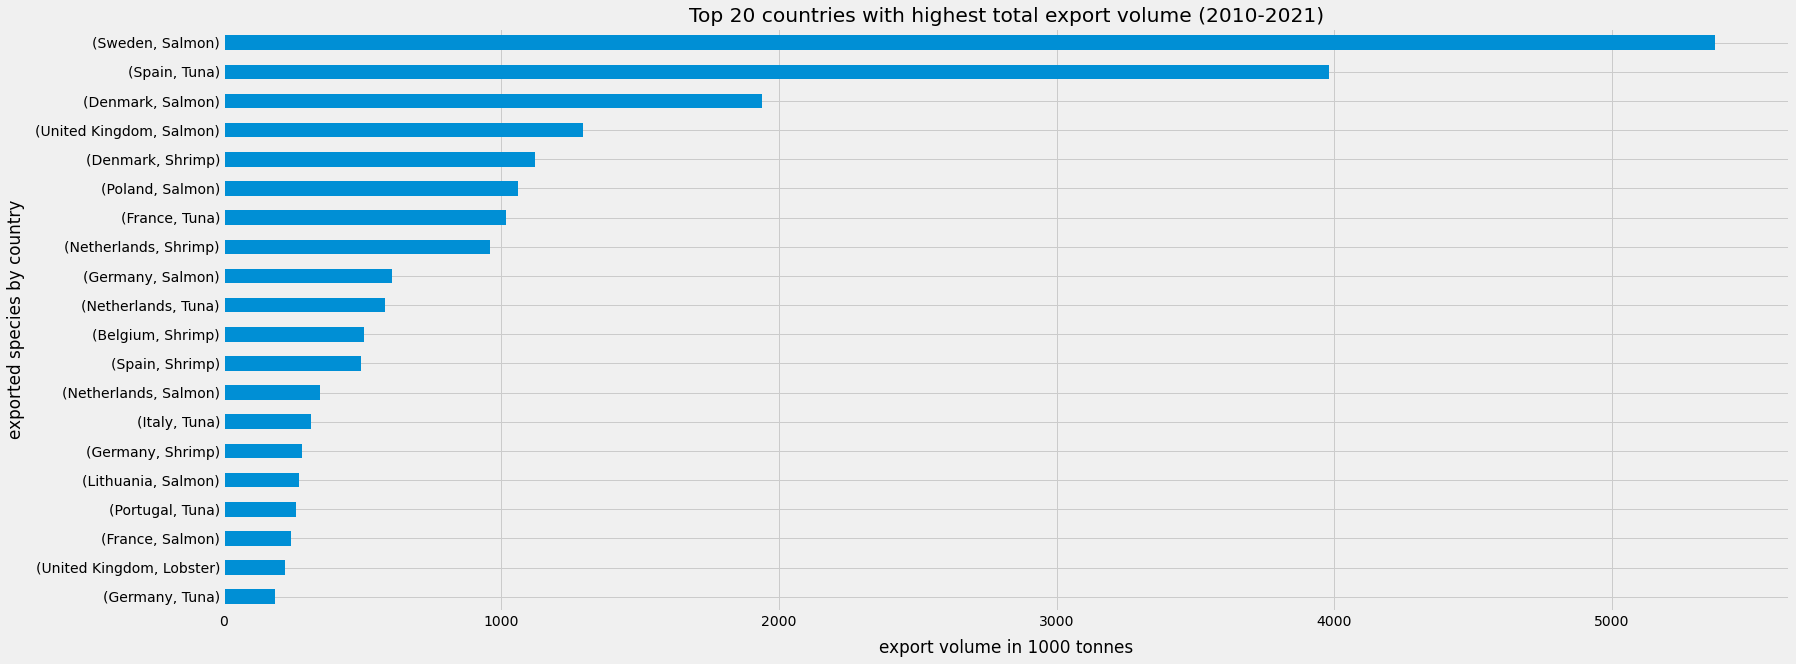

In [3065]:
# Visualize top 20 exporting countries 

top_20_volume_export = total_export_volume_europe1.nlargest(20,'volume_t')

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(25,10))
(
    top_20_volume_export
    .groupby(["country","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .sort_values(ascending=True) # sort the values in descending
    .plot.barh() # Make a bar chart based on the dataframe

)
ax.set_title('Top 20 countries with highest total export volume (2010-2021)')

ax.set_xlabel('export volume in 1000 tonnes',labelpad=10);
ax.set_ylabel('exported species by country',labelpad=10);

### Detail look in top 20 countries

### Yearly export volume of species in Sweden

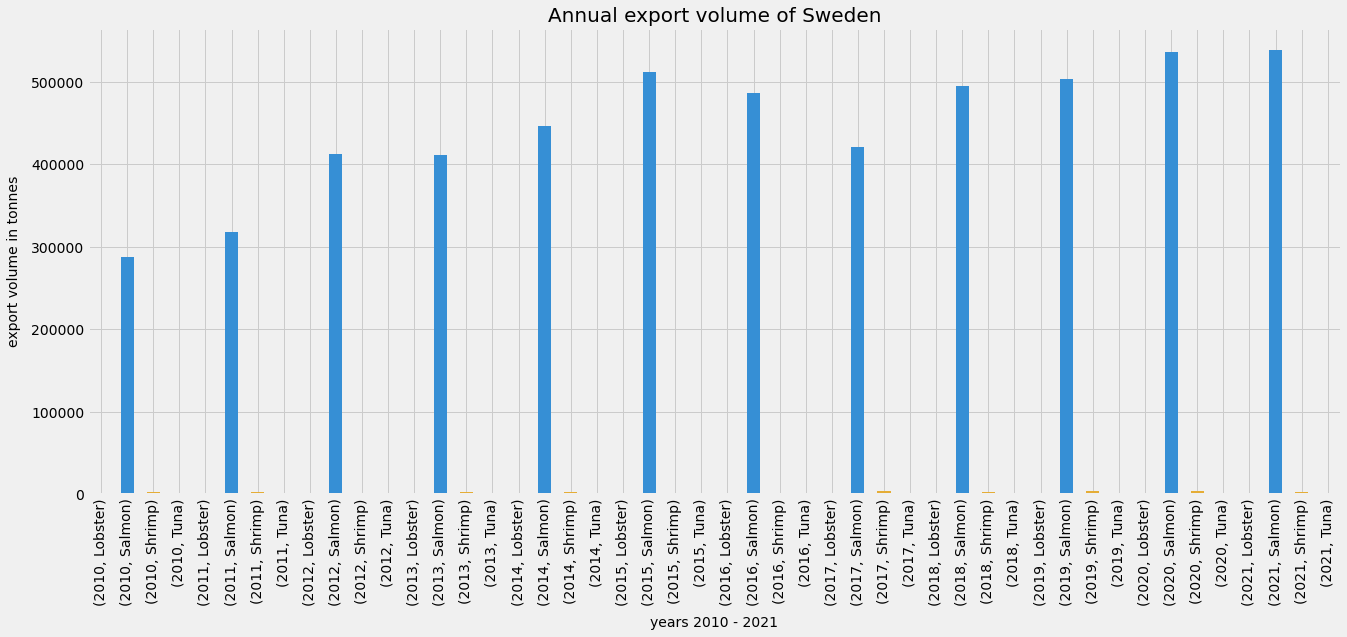

In [3066]:
#sweden_export_volume = trading_total_export.query("country == 'Sweden'").groupby(["year","main_commercial_species"]).sum()/1000

sweden_export_volume = trading_total_export.query("country == 'Sweden'")
#display(sweden_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    sweden_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t'] # count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Sweden', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in Spain

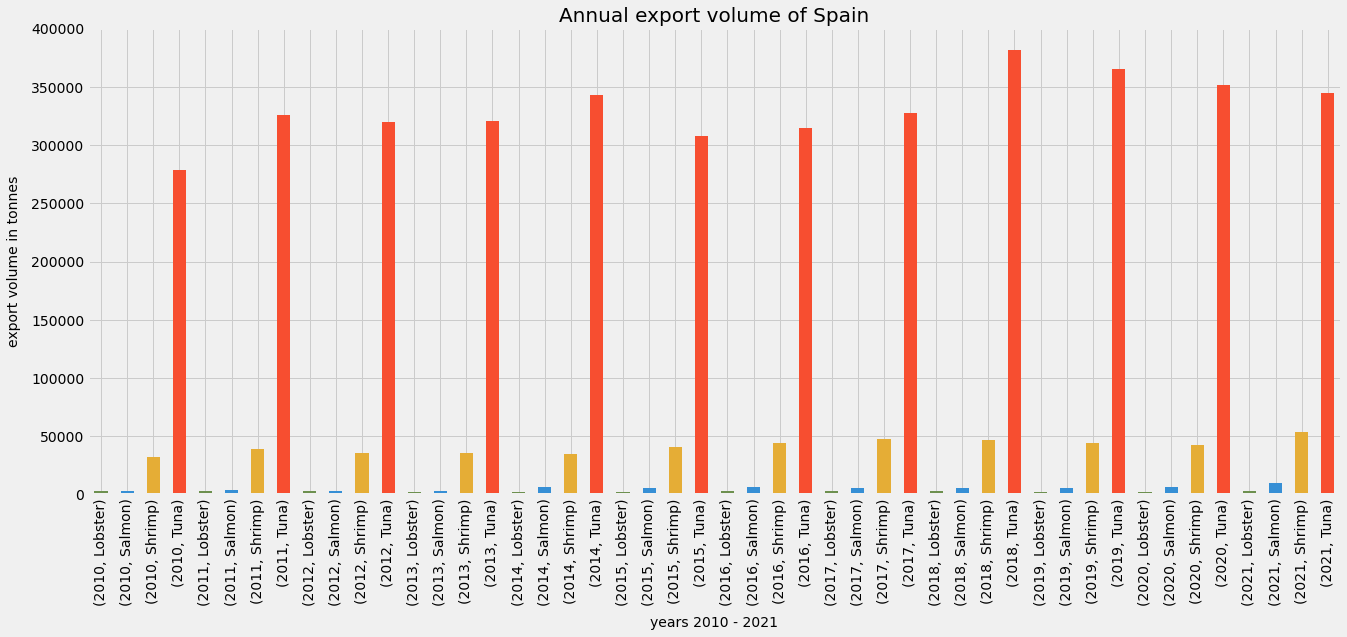

In [3067]:
spain_export_volume = trading_total_export.query("country == 'Spain'")
#display(spain_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    spain_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t'] # count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Spain', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in Denmark

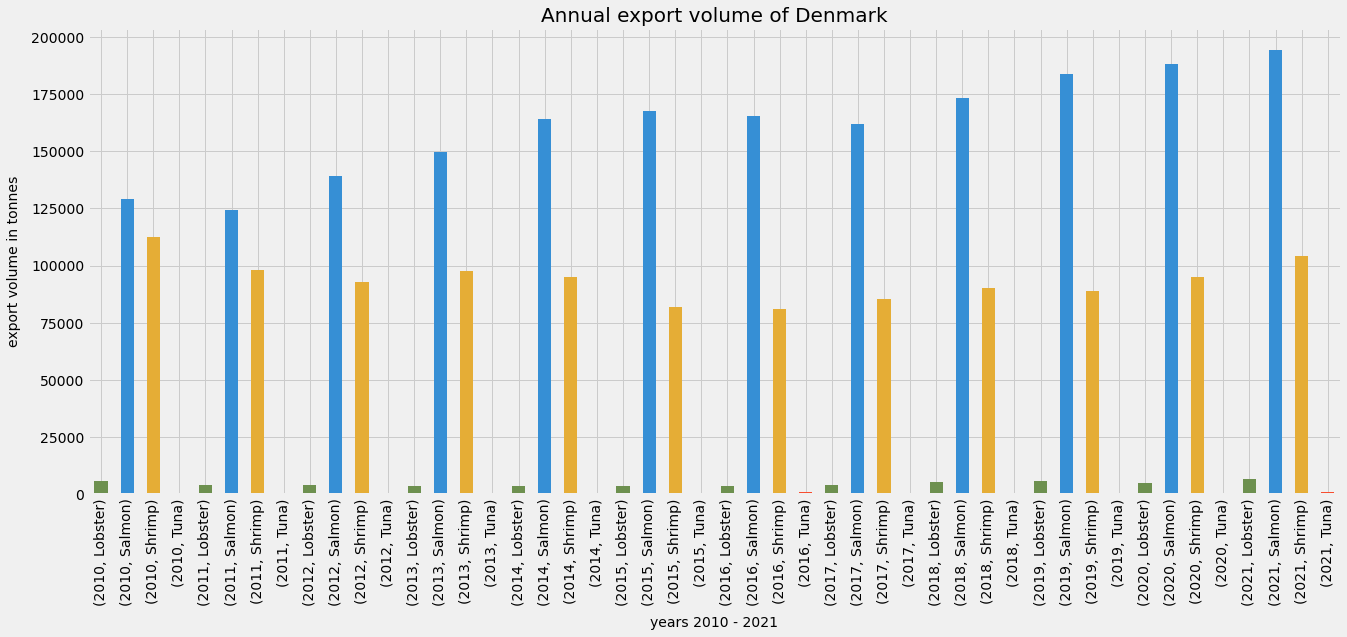

In [3068]:
denmark_export_volume = trading_total_export.query("country == 'Denmark'")
#display(denmark_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    denmark_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Denmark', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in France

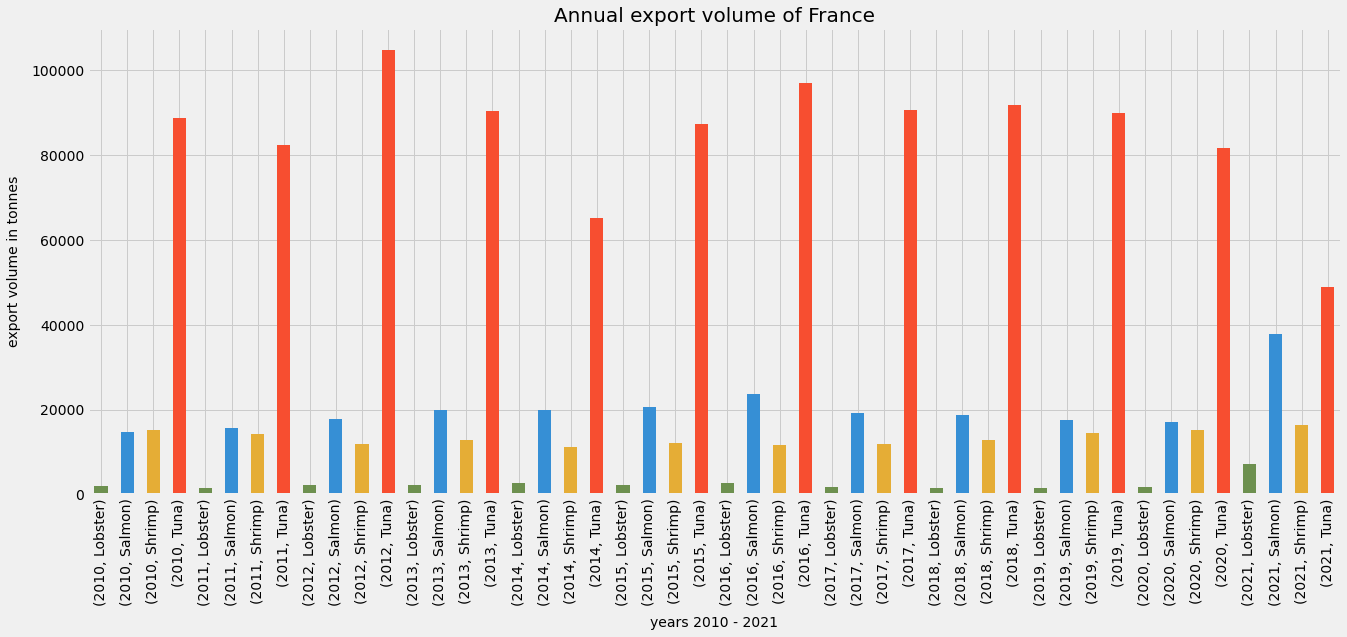

In [3069]:
france_export_volume = trading_total_export.query("country == 'France'")
#display(france_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    france_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of France', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in Italy

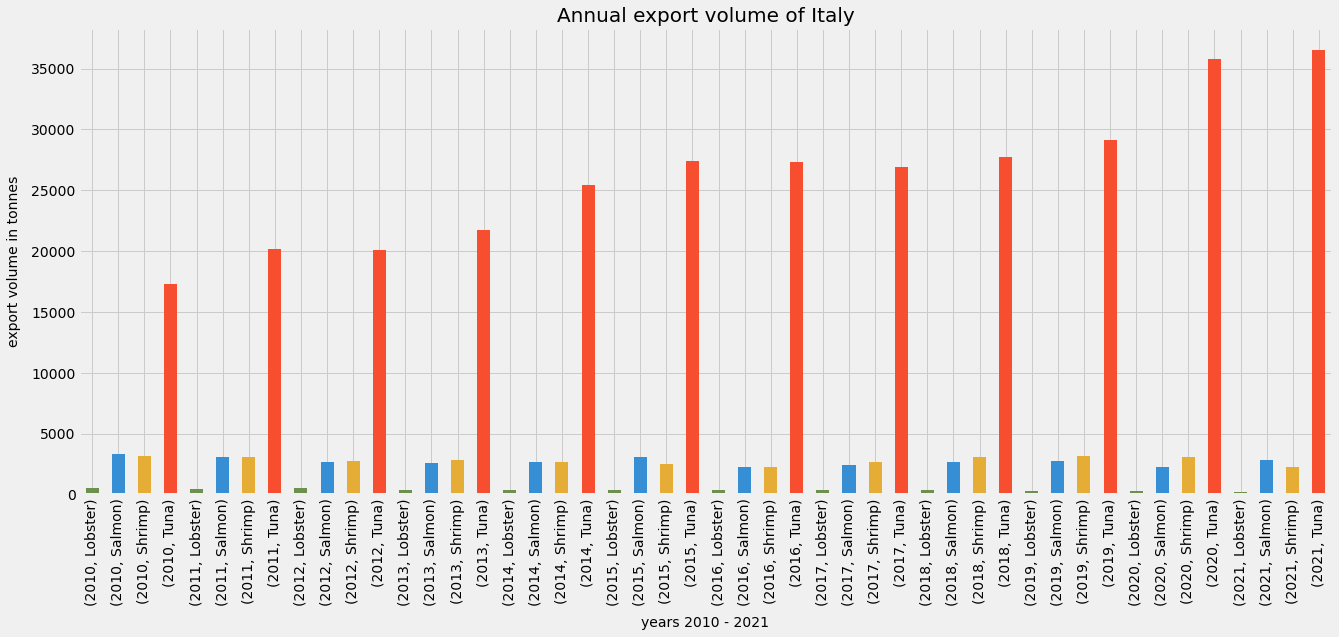

In [3070]:
italy_export_volume = trading_total_export.query("country == 'Italy'")
#display(italy_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    italy_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Italy', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in Germany

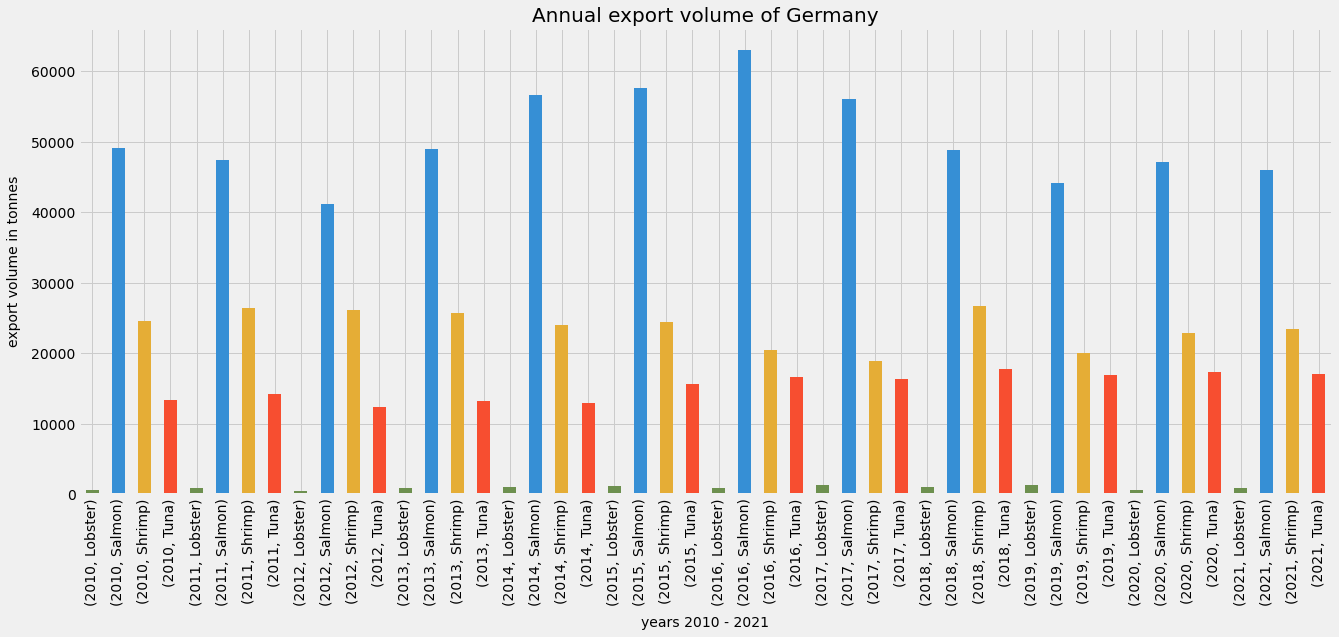

In [3071]:
germany_export_volume = trading_total_export.query("country == 'Germany'")
#display(germany_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    germany_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Germany', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in Poland

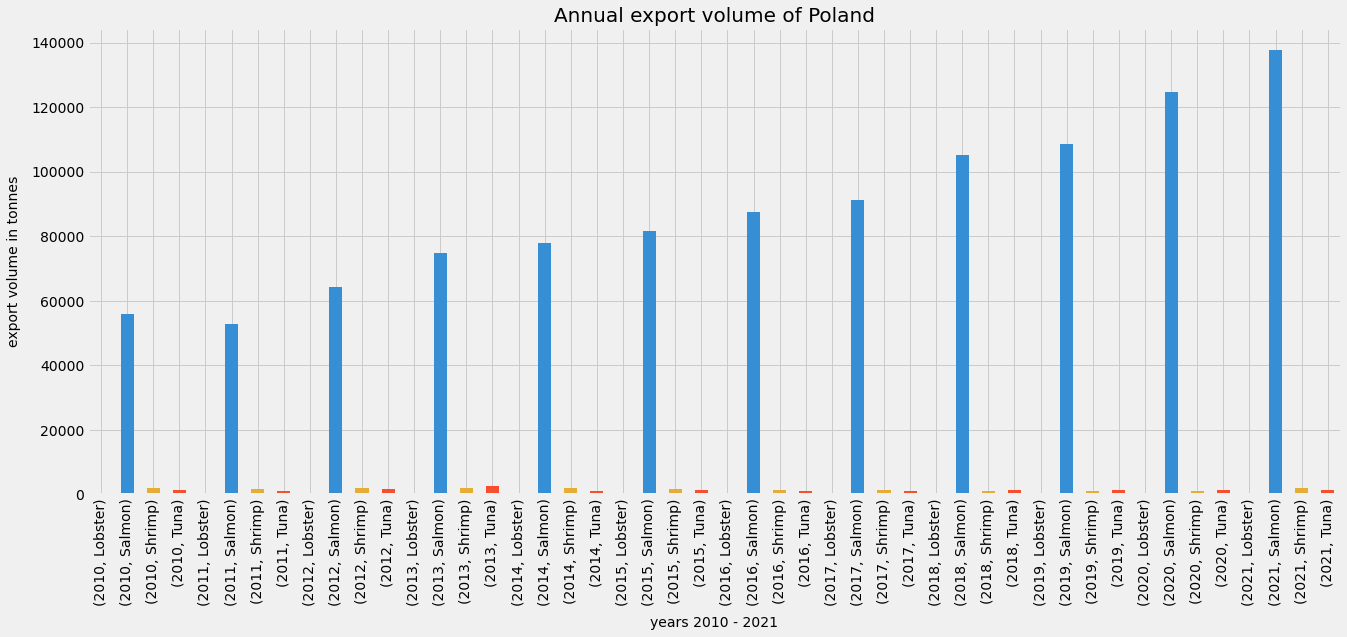

In [3072]:
poland_export_volume = trading_total_export.query("country == 'Poland'")
#display(poland_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    poland_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Poland', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in United Kingdom

In [3073]:
uk_export_volume = trading_total_export.query("country == 'United Kingdom'")
uk_export_volume.groupby(["year", "main_commercial_species"]).sum()

volume_t    value_eur  market_value_eur_per_t
year main_commercial_species                                               
2010 Lobster                  23457.06 177922699.00                32551.84
     Salmon                   84146.67 467267037.00                 5553.01
     Shrimp                   16438.38  96703000.00                42370.40
     Tuna                      6895.98  18184677.00                26945.52
2011 Lobster                  20856.17 186352989.00                30032.05
     Salmon                   97618.48 568809617.00                 5826.86
     Shrimp                   14727.20  93141961.00                40473.23
     Tuna                      4682.25  20644650.00               160255.73
2012 Lobster                  18630.93 175831161.00                30497.23
     Salmon                  101735.82 559301133.00                 5497.58
     Shrimp                   13567.30  89121363.00                27680.23
     Tuna                      7987.04  30130845.00                38106.06
2013 Lobster                  16997.57 159703711.00                30791.52
     Salmon                  113081.53 686962688.00                 6074.93
     Shrimp                   16083.69 100459553.00                28092.87
     Tuna                      6851.35  28610118.00                29859.10
2014 Lobster                  18960.25 185383111.00                31505.77
     Salmon                  124229.29 770357252.00                 6201.09
     Shrimp                   12525.57  88191111.00                30755.94
     Tuna                      5795.96  28055022.00                51901.81
2015 Lobster                  16796.56 183184219.00                36687.03
     Salmon                  112932.87 678627516.00                 6009.12
     Shrimp                   10836.44  92834279.00                43928.46
     Tuna                      5213.14  25723479.00                66443.72
2016 Lobster                  18324.76 201055516.00                35573.47
     Salmon                   99447.48 692628967.00                 6964.77
     Shrimp                   11779.60  98976848.00                38962.79
     Tuna                      5444.92  26081735.00                48751.49
2017 Lobster                  18372.42 206538121.00                38500.07
     Salmon                  115026.73 820626018.00                 7134.22
     Shrimp                   13247.30 114182703.00                52089.53
     Tuna                      4647.55  22178495.00                53055.40
2018 Lobster                  17338.50 189763890.00                40976.18
     Salmon                   99118.10 719388257.00                 7257.89
     Shrimp                   12510.01  94679878.00                37290.67
     Tuna                      7965.34  27924831.00                47235.19
2019 Lobster                  17785.58 190816489.00                40504.74
     Salmon                  123505.50 938353951.00                 7597.67
     Shrimp                   10688.63  82078358.00                29296.84
     Tuna                      4614.87  26037522.00                56412.73
2020 Lobster                  17562.04 190290189.50                40740.46
     Salmon                  111311.80 828871104.00                 7427.78
     Shrimp                   11599.32  88379118.00                33293.76
     Tuna                      6290.10  26981176.50                51823.96
2021 Lobster                  17562.04 190290189.50                40740.46
     Salmon                  111311.80 828871104.00                 7427.78
     Shrimp                   11599.32  88379118.00                33293.76
     Tuna                      6290.10  26981176.50                51823.96

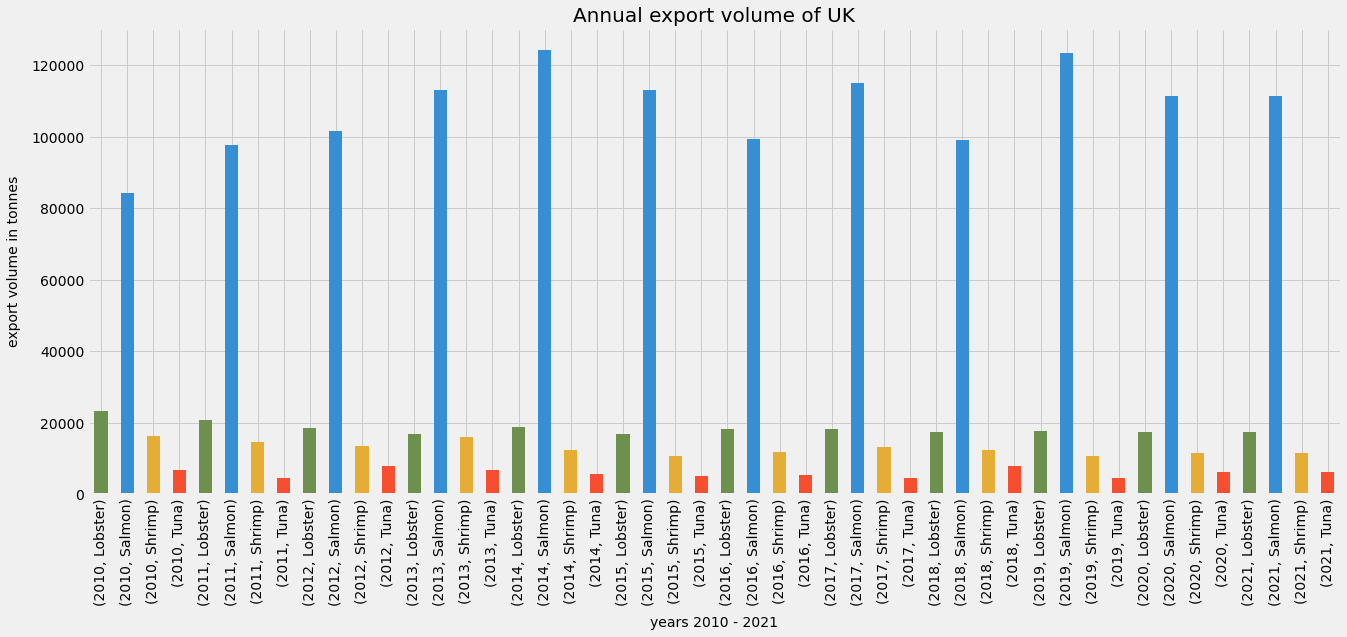

In [3074]:
# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    uk_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of UK', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in Netherlands

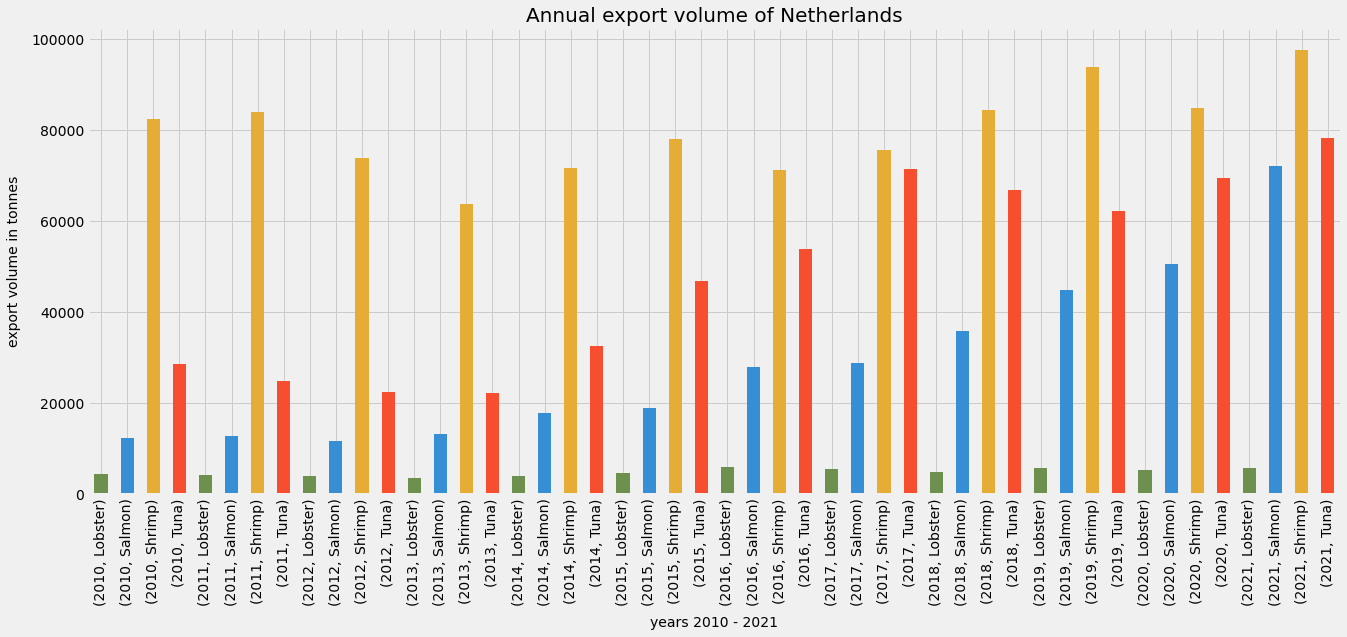

In [3075]:
netherlands_export_volume = trading_total_export.query("country == 'Netherlands'")
#display(netherlands_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    netherlands_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Netherlands', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Yearly export volume of species in Belgium

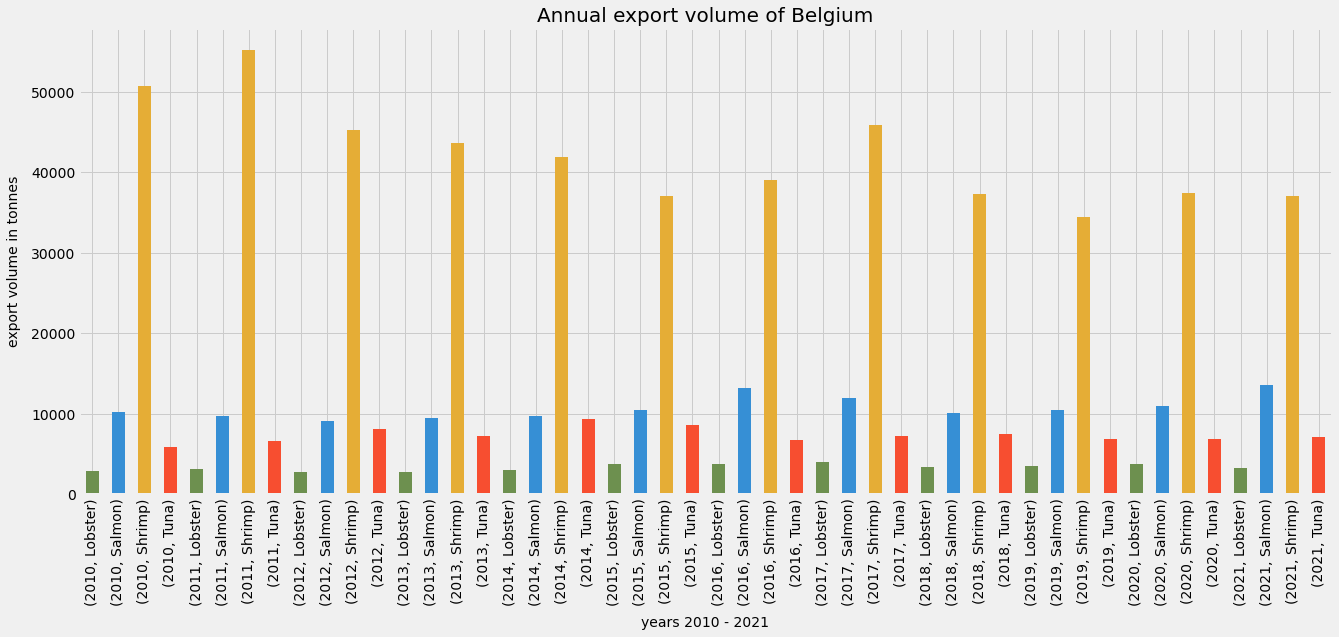

In [3076]:
belgium_export_volume = trading_total_export.query("country == 'Belgium'")
#display(belgium_export_volume)

# Plot line chart
fig, ax = plt.subplots(figsize=(20,8))
(
    belgium_export_volume
    .groupby(["year","main_commercial_species"]) # aggregate data to years and species
    .sum()['volume_t']# count total volume
    .plot.bar(color=['#6d904f', '#368fd5', '#e5ad36','#f74e30']) # Make a bar chart based on the dataframe

)
ax.set_title('Annual export volume of Belgium', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 14);
ax.set_ylabel('export volume in tonnes',labelpad=10, fontsize =14);


### Visualize annual total export volume of all main commercial species

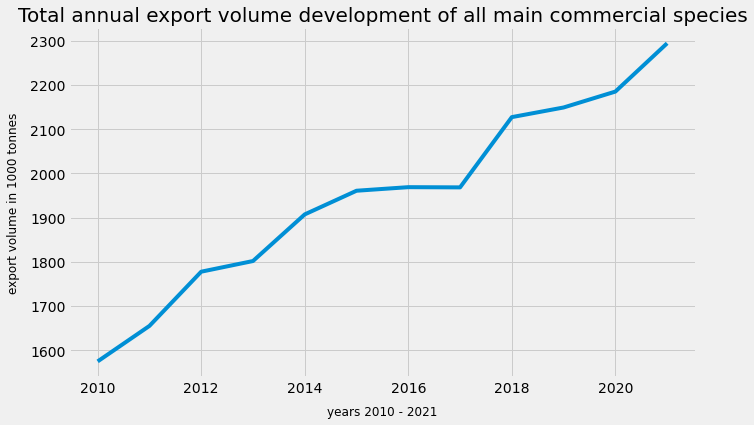

In [3077]:
# Visualize total export volume year by year
yearly_total_volume_export= trading_total_export.groupby("year").sum()/1000
#display(yearly_total_volume_export)

# Plot line chart
fig, ax = plt.subplots(figsize=(10,6))
(
    yearly_total_volume_export
    .groupby("year") # aggregate data to years
    .sum()['volume_t'] # count total volume
    .plot() # Make a line chart based on the dataframe

)
ax.set_title('Total annual export volume development of all main commercial species', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 12);
ax.set_ylabel('export volume in 1000 tonnes',labelpad=10, fontsize =12);

### Visualize annual total export value of all main commercial species

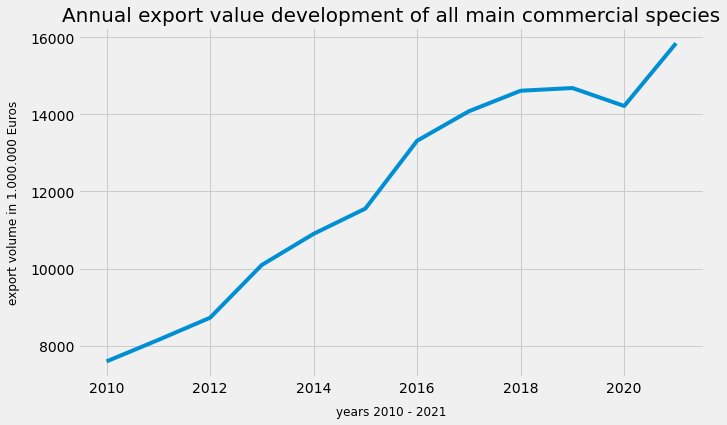

In [3078]:
# Visualize total export value year by year
#display(trading_total_export)

# Group by years and divide euros by 1.000.000 to make graph more readable
yearly_total_volume_export= trading_total_export.groupby("year").sum()/1000000

# Plot line chart 
fig, ax = plt.subplots(figsize=(10,6))
(
    yearly_total_volume_export
    .groupby("year") # aggregate data to years
    .sum()['value_eur'] # count total volume
    .plot() # Make a line chart based on the dataframe

)
ax.set_title('Annual export value development of all main commercial species', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 12);
ax.set_ylabel('export volume in 1.000.000 Euros',labelpad=10, fontsize =12);

### Development of total import volumes of species in detail year by year

### Salmon development of total export volumes 

,,volume_t,value_eur,market_value_eur_per_t
year,main_commercial_species,,,
2010,Salmon,685.48,4054367.40,276.06
2011,Salmon,730.92,4211424.49,157.63
2012,Salmon,870.59,4476139.74,173.93
2013,Salmon,913.31,5716218.34,208.71
2014,Salmon,992.39,6391543.99,230.57
2015,Salmon,1062.17,6746158.87,202.06
2016,Salmon,1044.08,8101459.23,254.49
2017,Salmon,995.86,8347872.15,267.42
2018,Salmon,1076.72,8734565.00,278.33


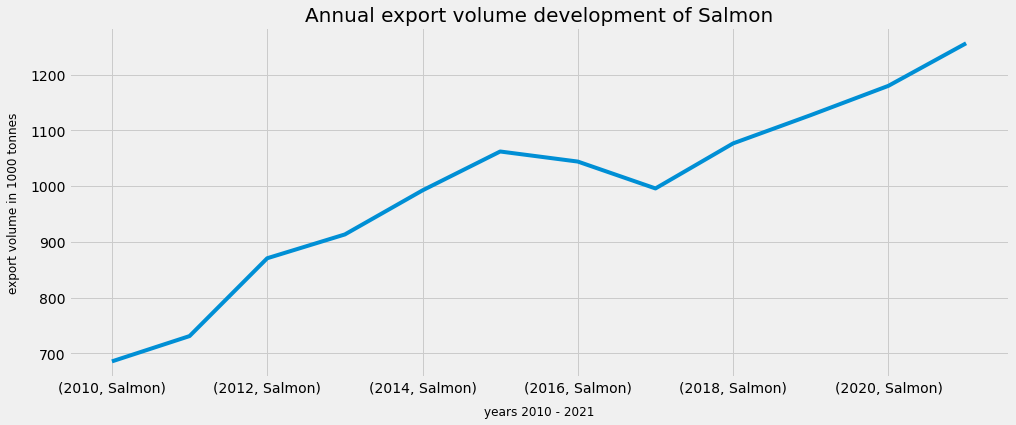

In [3079]:
# Visualize total export value of Salmon

# Group species and divide tonnes by 1.000 to make graph more readable
salmon_yearly_species_development_export= trading_total_export.query("main_commercial_species == 'Salmon'").groupby(["year","main_commercial_species"]).sum()/1000
display(salmon_yearly_species_development_export)

# Plot line chart
salmon = fig, ax = plt.subplots(figsize=(15,6))
(
    salmon_yearly_species_development_export
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)
ax.set_title('Annual export volume development of Salmon', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 12);
ax.set_ylabel('export volume in 1000 tonnes',labelpad=10, fontsize =12);

### Shrimp development of total export volumes 

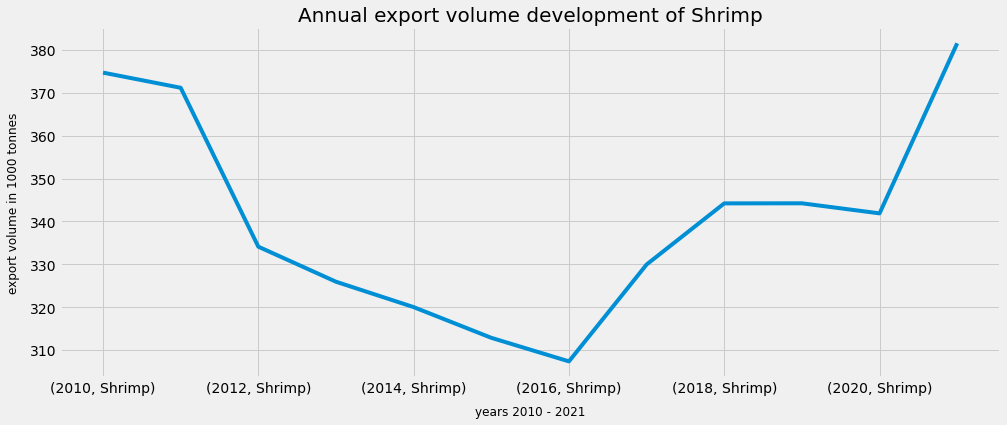

In [3080]:
# Visualize total export volumes of Shrimp

# Group species and divide tonnes by 1.000 to make graph more readable
shrimp_yearly_species_development_export= trading_total_export.query("main_commercial_species == 'Shrimp'").groupby(["year","main_commercial_species"]).sum()/1000
#display(shrimp_yearly_species_development_export)

# Plot line chart
fig, ax = plt.subplots(figsize=(15,6))
(
    shrimp_yearly_species_development_export
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)

ax.set_title('Annual export volume development of Shrimp', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 12);
ax.set_ylabel('export volume in 1000 tonnes',labelpad=10, fontsize =12);

### Tuna development of total export volumes 

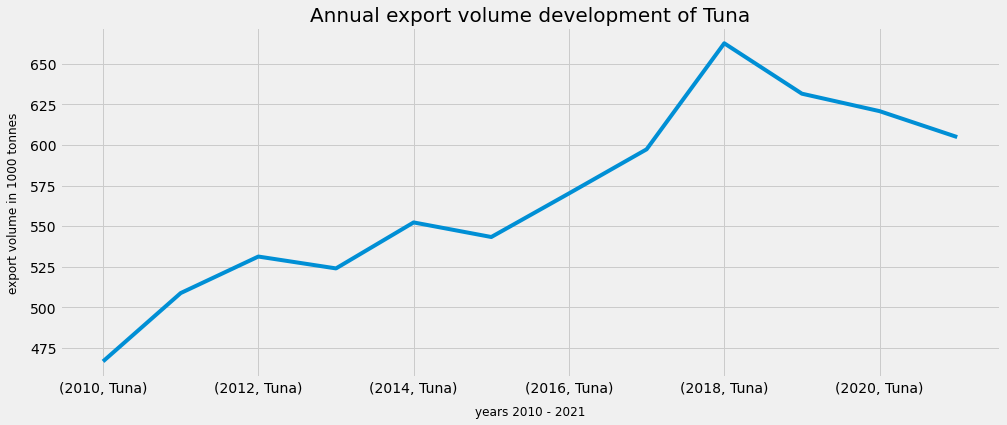

In [3081]:
# Visualize total export volumes of Tuna

# Group species and divide tonnes by 1.000 to make graph more readable
tuna_yearly_species_development_export= trading_total_export.query("main_commercial_species == 'Tuna'").groupby(["year","main_commercial_species"]).sum()/1000
#display(tuna_yearly_species_development_export)

# Plot line chart
fig, ax = plt.subplots(figsize=(15,6))
(
    tuna_yearly_species_development_export
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)

ax.set_title('Annual export volume development of Tuna', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 12);
ax.set_ylabel('export volume in 1000 tonnes',labelpad=10, fontsize =12);

### Lobster development of total import volumes 

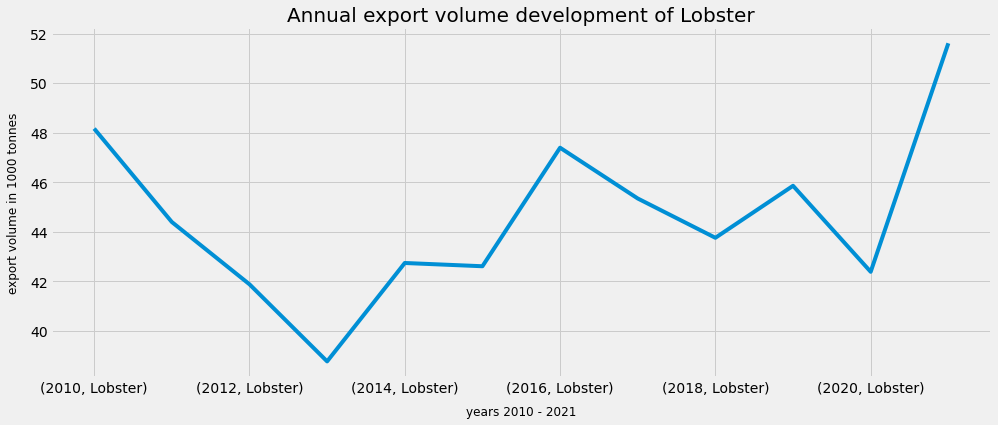

In [3082]:
# Visualize total export volumes of Lobster

# Group species and divide tonnes by 1.000 to make graph more readable
lobster_yearly_species_development_export= trading_total_export.query("main_commercial_species == 'Lobster'").groupby(["year","main_commercial_species"]).sum()/1000
#display(lobster_yearly_species_development)

# Plot line chart
fig, ax = plt.subplots(figsize=(15,6))
(
    lobster_yearly_species_development_export
    .groupby(["year","main_commercial_species"]) # aggregate data to level of airline
    .sum()['volume_t'] # count the observations
    .plot() # Make a line chart based on the dataframe

)

ax.set_title('Annual export volume development of Lobster', fontsize =20)
ax.set_xlabel('years 2010 - 2021',labelpad=10, fontsize= 12);
ax.set_ylabel('export volume in 1000 tonnes',labelpad=10, fontsize =12);

### Development of total annual import volumes of species in one graph

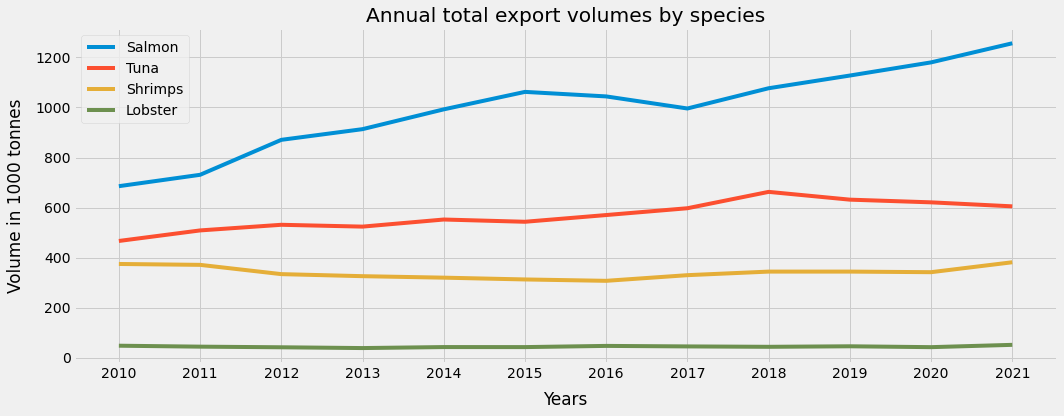

In [3083]:
# Visualize development of annual export volume of main commercial species

# Create labels and y-axes-values
labels = ['2010', '2011', '2012', '2013','2014','2015', '2016', '2017', '2018','2019','2020','2021']
shrimp_means_export = shrimp_yearly_species_development_export["volume_t"]
salmon_means_export = salmon_yearly_species_development_export["volume_t"]
lobster_means_export = lobster_yearly_species_development_export["volume_t"]
tuna_means_export = tuna_yearly_species_development_export["volume_t"]

x = np.arange(len(labels))  # the label locations

#plot the line charts
fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.plot(x, salmon_means_export,label='Salmon')
rects2 = ax.plot(x, tuna_means_export,label='Tuna')
rects3 = ax.plot(x, shrimp_means_export,label='Shrimps')
rects4 = ax.plot(x, lobster_means_export,label='Lobster')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Years',labelpad=10)
ax.set_ylabel('Volume in 1000 tonnes',labelpad=10)
ax.set_title('Annual total export volumes by species')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Development of total annual export value of species in one graph

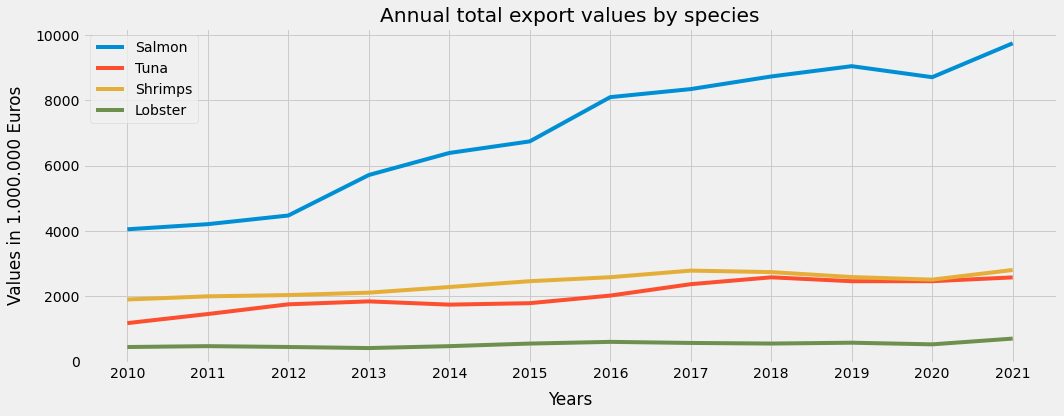

In [3084]:
# Visualize development of annual export values of main commercial species

# Group species and divide euros by 1.000.000 to make graph more readable
lobster_yearly_species_value_development_export= trading_total_export.query("main_commercial_species == 'Lobster'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(lobster_yearly_species_value_development)
shrimp_yearly_species_value_development_export= trading_total_export.query("main_commercial_species == 'Shrimp'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(shrimp_yearly_species_value_development)
tuna_yearly_species_value_development_export= trading_total_export.query("main_commercial_species == 'Tuna'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(tuna_yearly_species_value_development)
salmon_yearly_species_value_development_export= trading_total_export.query("main_commercial_species == 'Salmon'").groupby(["year","main_commercial_species"]).sum()/1000000
#display(salmon_yearly_species_value_development)

# Create labels and y-axes-values
labels = ['2010', '2011', '2012', '2013','2014','2015', '2016', '2017', '2018','2019','2020','2021']
shrimp_value_export = shrimp_yearly_species_value_development_export["value_eur"]
salmon_value_export = salmon_yearly_species_value_development_export["value_eur"]
lobster_value_export = lobster_yearly_species_value_development_export["value_eur"]
tuna_value_export = tuna_yearly_species_value_development_export["value_eur"]

x = np.arange(len(labels))  # the label locations

#Plot the line charts
fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.plot(x, salmon_value_export,label='Salmon')
rects2 = ax.plot(x, tuna_value_export, label='Tuna')
rects3 = ax.plot(x, shrimp_value_export,label='Shrimps')
rects4 = ax.plot(x, lobster_value_export,label='Lobster')


# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Years',labelpad=10)
ax.set_ylabel('Values in 1.000.000 Euros',labelpad=10)
ax.set_title('Annual total export values by species')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [3085]:
trading_total_export.head()

,year,country,main_commercial_species,categories_species,volume_t,value_eur,market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,1.60,35925.00,67562.93
1,2010,Austria,Shrimp,Crustaceans,244.09,2000431.00,48341.42
2,2010,Austria,Tuna,Pelagic fish,927.86,3108591.00,60318.00
3,2010,Austria,Salmon,Pelagic fish,310.91,2989229.00,9614.42
4,2010,Belgium,Lobster,Crustaceans,2870.50,44808625.00,42657.43


In [3086]:
# upload dataframe in dbeaver

table_name = 'trading_total_export_country_species'
engine = get_engine()
schema = 'capstone_fish_are_friends'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This may take some time ...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        trading_total_export.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The trading_total_export_country_species table was imported successfully.


## 1.2.b Species Categories

## 2. Approximated Consume Calculation

In [3087]:
# Minor changes to dataframe selected production country

#Rename columns
selected_production_country["main_commercial_species"] = selected_production_country["species"]

# Drop column "unit", "species"
selected_production_country.drop("species",axis=1,inplace=True)

# Rearrange order of columns in dataframe
selected_production_country = selected_production_country[['year', 'country', 'main_commercial_species','categories_species','production_volume_t']]

In [3088]:
# Rename old columns trading total import and export for better understanding
trading_total_import["import_volume_t"] = trading_total_import["volume_t"]
trading_total_export["export_volume_t"] = trading_total_export["volume_t"]

# Drop columns "volume_t"
trading_total_import.drop("volume_t",axis=1,inplace=True)
trading_total_export.drop("volume_t",axis=1,inplace=True)

# Rearrange order of columns in dataframe
trading_total_import = trading_total_import[['year', 'country', 'main_commercial_species','categories_species','import_volume_t','value_eur','market_value_eur_per_t']]
trading_total_export = trading_total_export[['year', 'country', 'main_commercial_species','categories_species','export_volume_t','value_eur','market_value_eur_per_t']]

In [3089]:
# Merge all three dataframes
#merge trading_total_import and trading_total_export dataframe
merged1= trading_total_import.merge(trading_total_export, how="left", on=["year","country","main_commercial_species","categories_species"])
merged1

merged1.rename(columns={"value_eur_x":"import_value_eur","market_value_eur_per_t_x":"import_market_value_eur_per_t","value_eur_y":"export_value_eur","market_value_eur_per_t_y":"export_market_value_eur_per_t"},inplace=True)
merged1

,year,country,main_commercial_species,categories_species,import_volume_t,import_value_eur,import_market_value_eur_per_t,export_volume_t,export_value_eur,export_market_value_eur_per_t
0,2010,Austria,Lobster,Crustaceans,147.38,2405963.00,49711.50,1.60,35925.00,67562.93
1,2010,Austria,Shrimp,Crustaceans,4412.82,32462723.00,45279.72,244.09,2000431.00,48341.42
2,2010,Austria,Tuna,Pelagic fish,9092.00,34975793.00,42071.28,927.86,3108591.00,60318.00
3,2010,Austria,Salmon,Pelagic fish,7076.20,59317843.00,8382.73,310.91,2989229.00,9614.42
4,2010,Belgium,Lobster,Crustaceans,4879.10,66587547.00,41348.17,2870.50,44808625.00,42657.43
...,...,...,...,...,...,...,...,...,...,...
1339,2021,Sweden,Salmon,Pelagic fish,582427.00,3569818000.00,6129.21,538387.00,3356037000.00,6233.50
1340,2021,United Kingdom,Lobster,Crustaceans,4295.91,48810908.00,42105.28,17562.04,190290189.50,40740.46
1341,2021,United Kingdom,Shrimp,Crustaceans,78174.98,712761506.50,56192.56,11599.32,88379118.00,33293.76
1342,2021,United Kingdom,Tuna,Pelagic fish,108783.93,489753186.50,56034.90,6290.10,26981176.50,51823.96


In [3090]:
# Show dataframes which are going to be merged
selected_production_country.info()
merged1.info()

#change datatype years to int for merging
merged1.year = merged1.year.astype(int)
merged1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     1084 non-null   int64  
 1   country                  1084 non-null   object 
 2   main_commercial_species  1084 non-null   object 
 3   categories_species       1084 non-null   object 
 4   production_volume_t      1084 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 42.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1344 entries, 0 to 1343
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   year                           1344 non-null   object 
 1   country                        1344 non-null   object 
 2   main_commercial_species        1344 non-null   object 
 3   categories_species             1344 non-n

In [3091]:
# Merge merge1 and selected_production_country
#display(merged1.head())
#display(selected_production_country.head())

total_trading_table_eu = merged1.merge(selected_production_country, how="left", on=["year","country","main_commercial_species","categories_species"])
total_trading_table_eu

,year,country,main_commercial_species,categories_species,import_volume_t,import_value_eur,import_market_value_eur_per_t,export_volume_t,export_value_eur,export_market_value_eur_per_t,production_volume_t
0,2010,Austria,Lobster,Crustaceans,147.38,2405963.00,49711.50,1.60,35925.00,67562.93,NaN
1,2010,Austria,Shrimp,Crustaceans,4412.82,32462723.00,45279.72,244.09,2000431.00,48341.42,NaN
2,2010,Austria,Tuna,Pelagic fish,9092.00,34975793.00,42071.28,927.86,3108591.00,60318.00,NaN
3,2010,Austria,Salmon,Pelagic fish,7076.20,59317843.00,8382.73,310.91,2989229.00,9614.42,1639.00
4,2010,Belgium,Lobster,Crustaceans,4879.10,66587547.00,41348.17,2870.50,44808625.00,42657.43,144.40
...,...,...,...,...,...,...,...,...,...,...,...
1339,2021,Sweden,Salmon,Pelagic fish,582427.00,3569818000.00,6129.21,538387.00,3356037000.00,6233.50,10774.01
1340,2021,United Kingdom,Lobster,Crustaceans,4295.91,48810908.00,42105.28,17562.04,190290189.50,40740.46,33217.25
1341,2021,United Kingdom,Shrimp,Crustaceans,78174.98,712761506.50,56192.56,11599.32,88379118.00,33293.76,1578.32
1342,2021,United Kingdom,Tuna,Pelagic fish,108783.93,489753186.50,56034.90,6290.10,26981176.50,51823.96,672.25


In [3092]:
# Fill NaN Values in dataframe with 0
total_trading_table_eu.fillna(0, inplace=True)

# Create new column "approximated consume"
total_trading_table_eu["approx_consumption_t"] = (total_trading_table_eu["import_volume_t"] + total_trading_table_eu["production_volume_t"]) - total_trading_table_eu["export_volume_t"]

In [3093]:
#total_trading_table_eu.head(50)
total_trading_table_eu.query("country == 'Belgium' and main_commercial_species == 'Lobster'").sort_values(by="approx_consumption_t", ascending=False)

,year,country,main_commercial_species,categories_species,import_volume_t,import_value_eur,import_market_value_eur_per_t,export_volume_t,export_value_eur,export_market_value_eur_per_t,production_volume_t,approx_consumption_t
1236,2021,Belgium,Lobster,Crustaceans,4840.00,109183000.00,62951.95,3247.00,77064000.00,65837.15,681.00,2274.00
4,2010,Belgium,Lobster,Crustaceans,4879.10,66587547.00,41348.17,2870.50,44808625.00,42657.43,144.40,2153.00
452,2014,Belgium,Lobster,Crustaceans,4480.19,68621291.00,49210.78,2976.42,44758699.00,45036.06,505.40,2009.17
340,2013,Belgium,Lobster,Crustaceans,4326.30,64931931.00,48149.75,2772.80,40990968.00,43048.07,318.70,1872.20
116,2011,Belgium,Lobster,Crustaceans,4700.00,69556968.00,45899.20,3170.00,51154865.00,45485.95,308.30,1838.30
676,2016,Belgium,Lobster,Crustaceans,4639.95,89088823.00,57336.73,3761.01,69623492.00,52728.72,887.10,1766.03
228,2012,Belgium,Lobster,Crustaceans,4118.30,60632617.00,47800.97,2795.60,42373548.00,44287.81,383.20,1705.90
788,2017,Belgium,Lobster,Crustaceans,4583.51,86392759.00,55328.96,3997.93,67642644.00,47576.47,1118.60,1704.18
900,2018,Belgium,Lobster,Crustaceans,4279.52,78818587.00,53667.90,3441.66,59678532.00,48777.58,654.10,1491.96
1124,2020,Belgium,Lobster,Crustaceans,4533.54,82847031.00,54577.31,3785.20,63981846.00,47763.82,681.00,1429.34


In [3094]:
# upload dataframe in dbeaver

table_name = 'total_trading_table_eu'
engine = get_engine()
schema = 'capstone_fish_are_friends'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This may take some time ...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        total_trading_table_eu.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The total_trading_table_eu table was imported successfully.
